<center> Statistical Thinking in Data Science <center>

# Exploratory Data Analysis & Modelling - AT2

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
from tqdm import tqdm
import itertools


from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.gridspec import GridSpec
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.stats.diagnostic import het_arch
import statsmodels.api as sm

from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from scipy.stats import shapiro

from arch import arch_model
import arch

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

from statsmodels.tsa.api import VAR
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, SeasonalExponentialSmoothing
import warnings

warnings.filterwarnings('ignore')

In [66]:
# load data 
QLD_data = pd.read_csv('D:\\S1Y1 UTS\\statistical thinking for ds\\asm 2\\stds-electricityTS\\raw_data\\combined_QLD.csv')
NSW_data = pd.read_csv('D:\\S1Y1 UTS\\statistical thinking for ds\\asm 2\\stds-electricityTS\\raw_data\\combined_NSW.csv')
VIC_data = pd.read_csv('D:\\S1Y1 UTS\\statistical thinking for ds\\asm 2\\stds-electricityTS\\raw_data\\Combined_VIC.csv')

In [67]:
weather_data = pd.read_csv('D:\\S1Y1 UTS\\statistical thinking for ds\\asm 2\\stds-electricityTS\\avg_weather_20180101_20250911.csv')

# Data Preprocessing

In [68]:
dataset_list = [("QLD_data", QLD_data), ("NSW_data", NSW_data), ("VIC_data", VIC_data)]
for name, data in dataset_list:
    print(f'{name} information{"-"*30}')
    data.info()
    print('\n')

QLD_data information------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258451 entries, 0 to 258450
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   REGION          258451 non-null  object
 1   SETTLEMENTDATE  258450 non-null  object
 2   TOTALDEMAND     258450 non-null  object
 3   RRP             258450 non-null  object
 4   PERIODTYPE      258450 non-null  object
dtypes: object(5)
memory usage: 9.9+ MB


NSW_data information------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248594 entries, 0 to 248593
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   REGION          248594 non-null  object
 1   SETTLEMENTDATE  248593 non-null  object
 2   TOTALDEMAND     248593 non-null  object
 3   RRP             248593 non-null  object
 4   PERIODTYPE      248593 non-null  object
dtypes

In [69]:
# when merging the data, some headers from other tables are included, hence we need to drop those rows
for data in [QLD_data, NSW_data, VIC_data]:
    data.drop(data[data['REGION'] == 'REGION'].index, inplace=True)
    data.dropna(subset=['SETTLEMENTDATE'], inplace=True)

In [70]:
# convert date / hour columns to datetime format
for data in [QLD_data, NSW_data, VIC_data]:
    data['SETTLEMENTDATE'] = pd.to_datetime(data['SETTLEMENTDATE'], format='mixed', dayfirst=True)

In [71]:
# convert totaldemand to numeric
for data in [QLD_data, NSW_data, VIC_data]:
    data['TOTALDEMAND'] = pd.to_numeric(data['TOTALDEMAND'])

In [72]:
dataset_list = [("QLD_data", QLD_data), ("NSW_data", NSW_data), ("VIC_data", VIC_data)]
for name, data in dataset_list:
    print(f'{name} information{"-"*30}')
    data.info()
    print('\n')

QLD_data information------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 258384 entries, 0 to 258449
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   REGION          258384 non-null  object        
 1   SETTLEMENTDATE  258384 non-null  datetime64[ns]
 2   TOTALDEMAND     258384 non-null  float64       
 3   RRP             258384 non-null  object        
 4   PERIODTYPE      258384 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 11.8+ MB


NSW_data information------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 248592 entries, 0 to 248592
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   REGION          248592 non-null  object        
 1   SETTLEMENTDATE  248592 non-null  datetime64[ns]
 2   TOTALDEMAND     248592 non

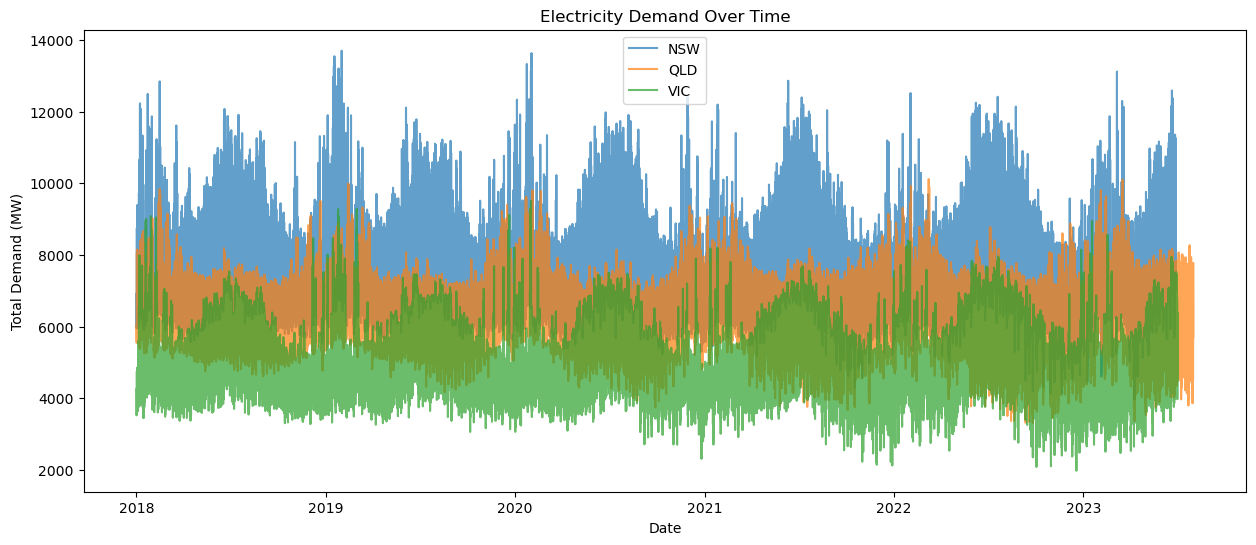

In [73]:
plt.figure(figsize=(15, 6))
plt.plot(NSW_data['SETTLEMENTDATE'], NSW_data['TOTALDEMAND'], label='NSW', alpha=0.7)
plt.plot(QLD_data['SETTLEMENTDATE'], QLD_data['TOTALDEMAND'], label='QLD', alpha=0.7)
plt.plot(VIC_data['SETTLEMENTDATE'], VIC_data['TOTALDEMAND'], label='VIC', alpha=0.7)
plt.title('Electricity Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Total Demand (MW)')
plt.legend()
plt.show()

# Seasonality

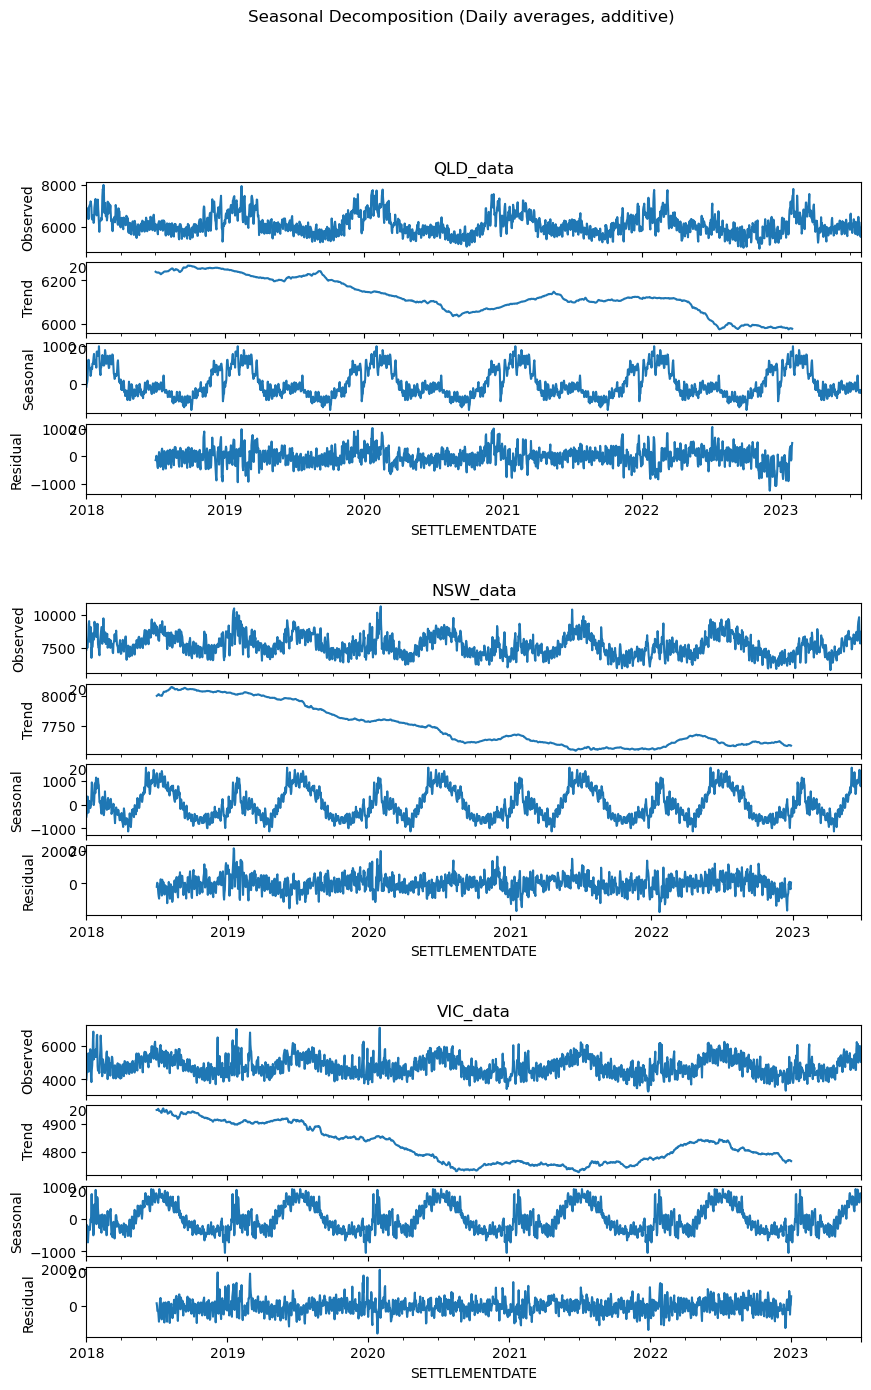

In [74]:
fig = plt.figure(figsize=(10, 5*len(dataset_list)))
outer = GridSpec(len(dataset_list), 1, hspace=0.35)

for i, (name, df) in enumerate(dataset_list):
    df = df.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')
    y = df['TOTALDEMAND'].resample('D').mean().dropna()      # daily avg

    result = seasonal_decompose(y, model='additive', period=365)  # daily → yearly cycle

    inner = GridSpecFromSubplotSpec(4, 1, subplot_spec=outer[i], hspace=0.15)
    ax0 = plt.Subplot(fig, inner[0]); result.observed.plot(ax=ax0); ax0.set_title(name); ax0.set_ylabel('Observed'); fig.add_subplot(ax0)
    ax1 = plt.Subplot(fig, inner[1]); result.trend.plot(ax=ax1);    ax1.set_ylabel('Trend');    fig.add_subplot(ax1)
    ax2 = plt.Subplot(fig, inner[2]); result.seasonal.plot(ax=ax2); ax2.set_ylabel('Seasonal'); fig.add_subplot(ax2)
    ax3 = plt.Subplot(fig, inner[3]); result.resid.plot(ax=ax3);    ax3.set_ylabel('Residual'); fig.add_subplot(ax3)

fig.suptitle('Seasonal Decomposition (Daily averages, additive)', y=0.995)
plt.tight_layout()
plt.show()

🔎 NSW

Trend: steady decline from 2018–2021, then flattening. Likely reflects efficiency improvements, rooftop solar, or economic shifts.

Seasonal: strong yearly cycle — winter heating + summer cooling demand visible as peaks.

Residual: noise around events (heatwaves, system shocks).

🔎 QLD

Trend: more stable, but still downward drift after 2020, then sharper fall in late 2022.

Seasonal: clear yearly cycle, though smaller amplitude than NSW.

Residual: a bit noisier, QLD has more weather-driven spikes.

🔎 VIC

Trend: gradual decline, with some recovery in 2022.

Seasonal: very consistent annual seasonality — winter peaks stand out.

Residual: spikes in 2019–2020 (likely extreme events).

# Frequency Dynamics

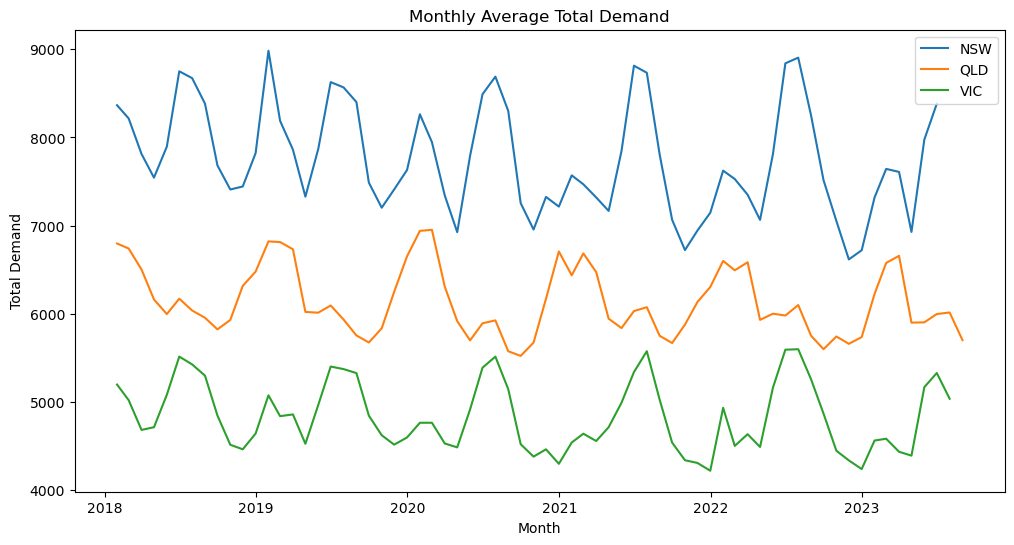

In [75]:
# resample the data to quarter frequency and calculate the mean
NSW = NSW_data.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')['TOTALDEMAND']
QLD = QLD_data.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')['TOTALDEMAND']
VIC = VIC_data.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')['TOTALDEMAND']

NSW_m = NSW.resample('M').mean().rename('NSW')
QLD_m = QLD.resample('M').mean().rename('QLD')
VIC_m = VIC.resample('M').mean().rename('VIC')

plt.figure(figsize=(12,6))
plt.plot(NSW_m.index, NSW_m.values, label='NSW')
plt.plot(QLD_m.index, QLD_m.values, label='QLD')
plt.plot(VIC_m.index, VIC_m.values, label='VIC')
plt.title('Monthly Average Total Demand')
plt.xlabel('Month')
plt.ylabel('Total Demand')
plt.legend()
plt.show()

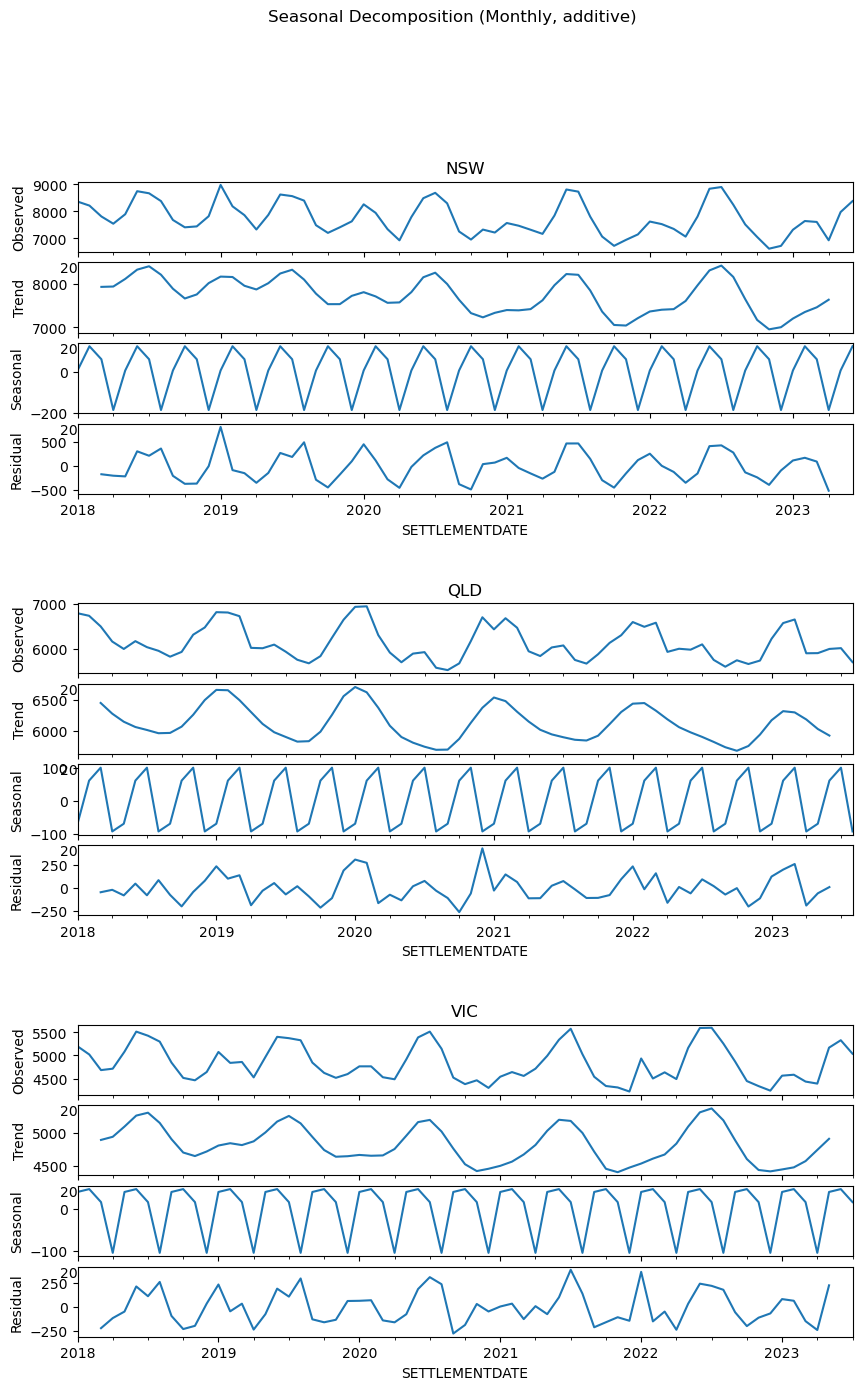

In [76]:
q_datalist = [("NSW", NSW_m), ("QLD", QLD_m), ("VIC", VIC_m)]
fig = plt.figure(figsize=(10, 5*len(q_datalist)))
outer = GridSpec(len(q_datalist), 1, hspace=0.35)

for i, (name, df) in enumerate(q_datalist):
    y = df.sort_index().dropna()           # Series with DatetimeIndex
    result = seasonal_decompose(y, model='additive', period=4)  # 4 quarters = yearly cycle

    inner = GridSpecFromSubplotSpec(4, 1, subplot_spec=outer[i], hspace=0.15)
    ax0 = plt.Subplot(fig, inner[0]); result.observed.plot(ax=ax0); ax0.set_title(name); ax0.set_ylabel('Observed'); fig.add_subplot(ax0)
    ax1 = plt.Subplot(fig, inner[1]); result.trend.plot(ax=ax1);    ax1.set_ylabel('Trend');    fig.add_subplot(ax1)
    ax2 = plt.Subplot(fig, inner[2]); result.seasonal.plot(ax=ax2); ax2.set_ylabel('Seasonal'); fig.add_subplot(ax2)
    ax3 = plt.Subplot(fig, inner[3]); result.resid.plot(ax=ax3);    ax3.set_ylabel('Residual'); fig.add_subplot(ax3)

fig.suptitle('Seasonal Decomposition (Monthly, additive)', y=0.995)
plt.tight_layout()
plt.show()

# Split Data

In [77]:
NSW_m = (NSW_data.set_index('SETTLEMENTDATE')['TOTALDEMAND']
         .resample('MS').mean().rename('NSW'))
QLD_m = (QLD_data.set_index('SETTLEMENTDATE')['TOTALDEMAND']
         .resample('MS').mean().rename('QLD'))
VIC_m = (VIC_data.set_index('SETTLEMENTDATE')['TOTALDEMAND']
         .resample('MS').mean().rename('VIC'))

In [78]:
train_cutoff = pd.to_datetime('2023-01-01')   # month-start
test_end     = pd.to_datetime('2023-04-02')   # include up to early April

def split_by_index(s, train_start=None, train_cutoff=None, test_end=None):
    s = s.sort_index()
    if train_start is None:
        train_start = s.index.min()
    train = s.loc[(s.index >= train_start) & (s.index < train_cutoff)]
    test  = s.loc[(s.index >= train_cutoff) & (s.index <= test_end)]
    return train, test

NSW_train, NSW_test = split_by_index(NSW_m, train_cutoff=train_cutoff, test_end=test_end)
QLD_train, QLD_test = split_by_index(QLD_m, train_cutoff=train_cutoff, test_end=test_end)
VIC_train, VIC_test = split_by_index(VIC_m, train_cutoff=train_cutoff, test_end=test_end)

print('NSW:', NSW_train.shape, NSW_test.shape,
      NSW_train.index.min(), '→', NSW_train.index.max(),
      '|', NSW_test.index.min(), '→', NSW_test.index.max())
print('QLD:', QLD_train.shape, QLD_test.shape,
      QLD_train.index.min(), '→', QLD_train.index.max(),
      '|', QLD_test.index.min(), '→', QLD_test.index.max())
print('VIC:', VIC_train.shape, VIC_test.shape,
      VIC_train.index.min(), '→', VIC_train.index.max(),
      '|', VIC_test.index.min(), '→', VIC_test.index.max())

NSW: (60,) (4,) 2018-01-01 00:00:00 → 2022-12-01 00:00:00 | 2023-01-01 00:00:00 → 2023-04-01 00:00:00
QLD: (60,) (4,) 2018-01-01 00:00:00 → 2022-12-01 00:00:00 | 2023-01-01 00:00:00 → 2023-04-01 00:00:00
VIC: (60,) (4,) 2018-01-01 00:00:00 → 2022-12-01 00:00:00 | 2023-01-01 00:00:00 → 2023-04-01 00:00:00


# EDA

*Insights*
- NSW highest consumption
- Apparent increase during winter season (May to Sep) across all states
- Clear cyclical and additive seasonal pattern since seasonal amp is roughly consistent

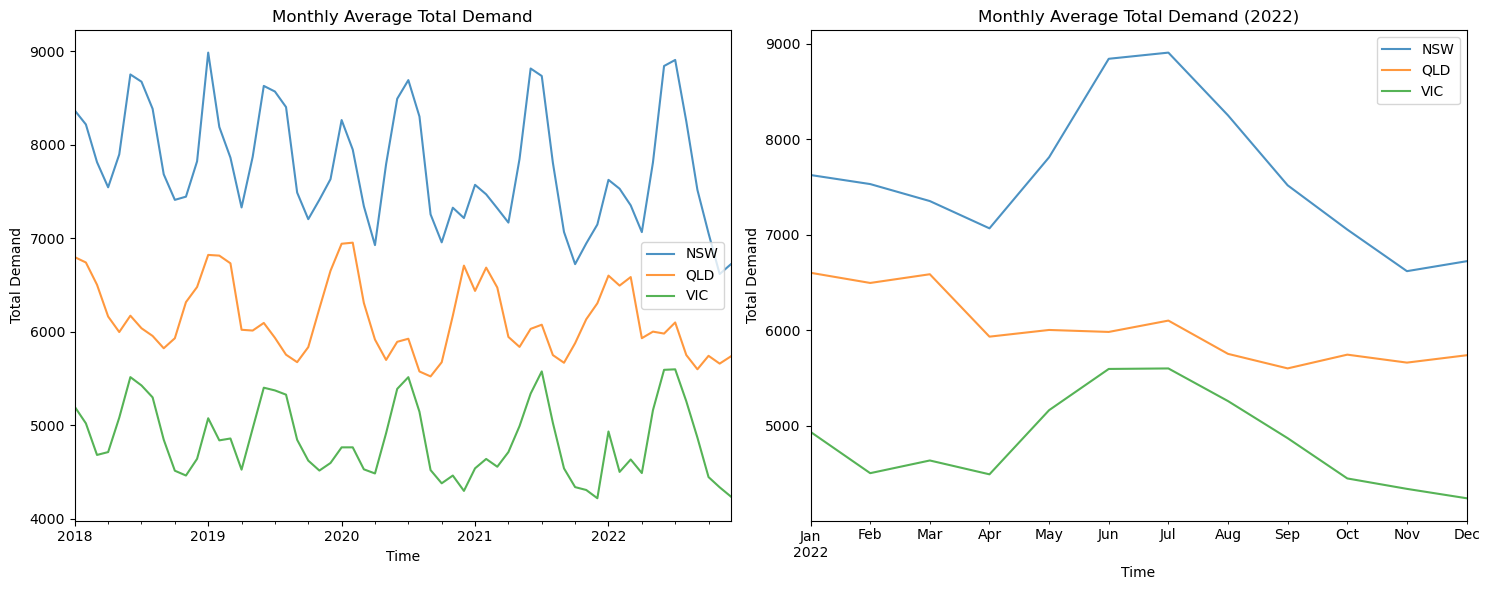

In [79]:
# plot the distribution of total demand over time for each state
train_list = {'NSW': NSW_train, 'QLD': QLD_train, 'VIC': VIC_train}
plt.figure(figsize=(15, 6))
plt.subplot(121)
for name, s in train_list.items():
    s.sort_index().plot(label=name, alpha=0.8)
plt.title("Monthly Average Total Demand")
plt.xlabel("Time"); plt.ylabel("Total Demand"); plt.legend()

plt.subplot(122)
start_date = '2022-01-01'
end_date   = '2022-12-31'

for name, s in train_list.items():
    s.sort_index().loc[start_date:end_date].plot(label=name, alpha=0.8)
plt.title("Monthly Average Total Demand (2022)")
plt.xlabel("Time"); plt.ylabel("Total Demand"); plt.legend()

plt.tight_layout()
plt.show()

## Stationary

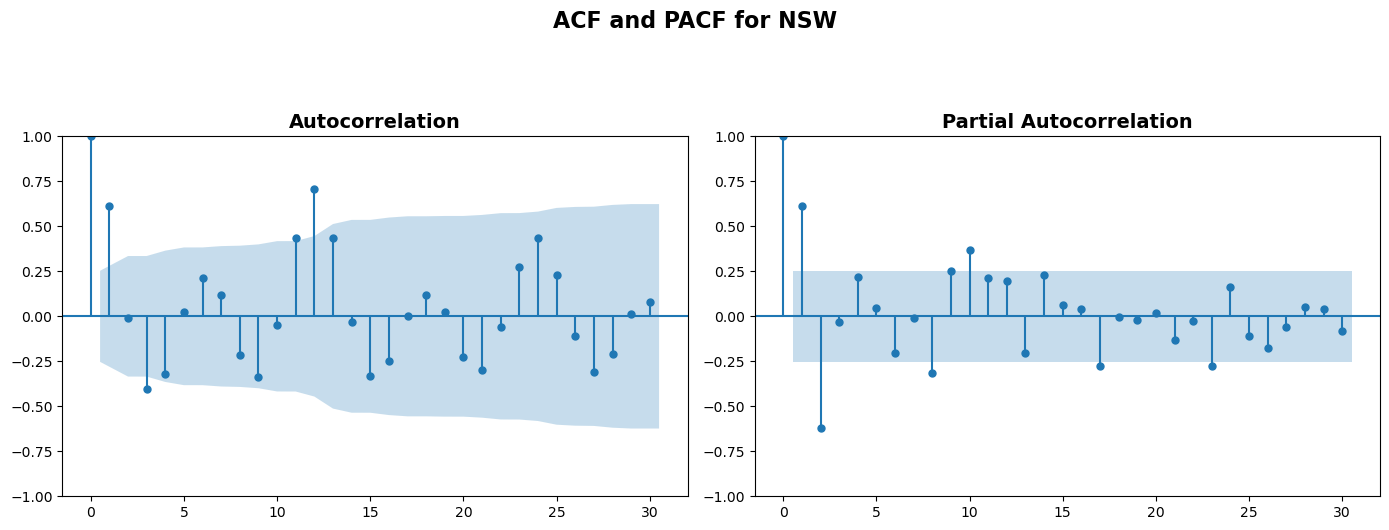

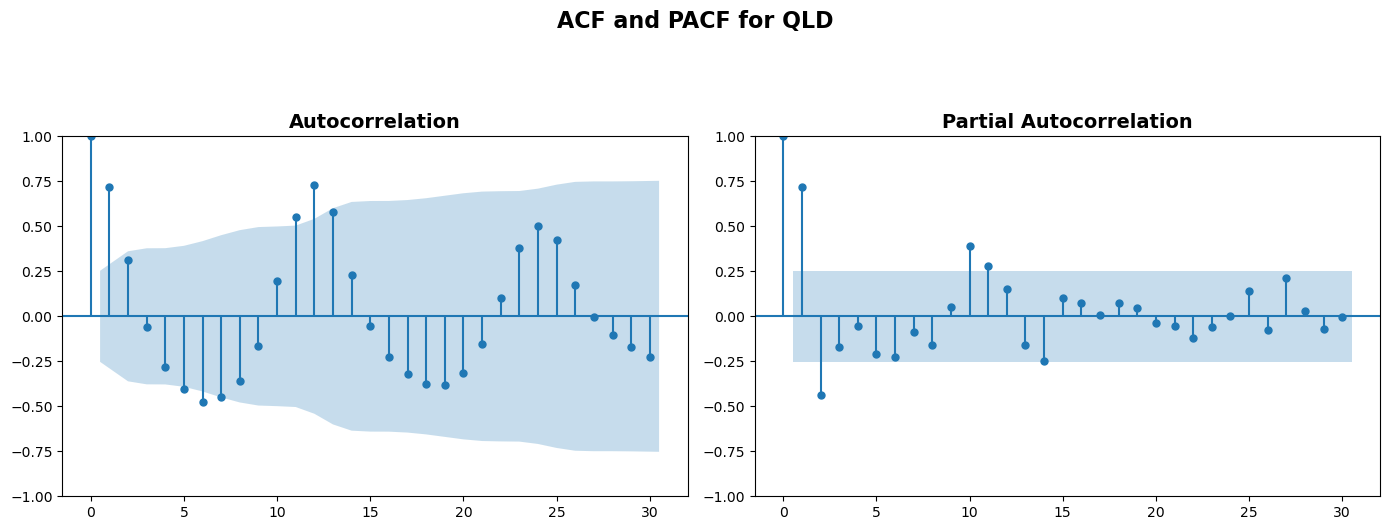

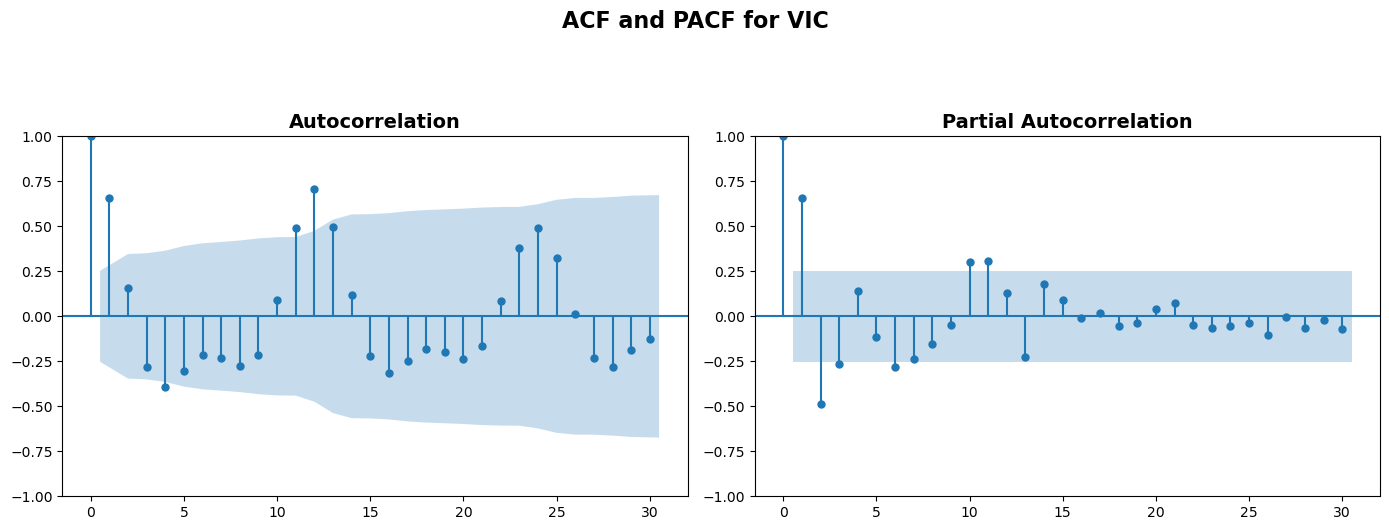

In [80]:
for name, series in train_list.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    
    # ACF
    sm.graphics.tsa.plot_acf(series, lags=30, alpha=0.05, ax=ax1)
    ax1.set_title("Autocorrelation", fontsize=14, fontweight="bold")
    
    # PACF
    sm.graphics.tsa.plot_pacf(series, lags=30, alpha=0.05, ax=ax2, method="ywm")
    ax2.set_title("Partial Autocorrelation", fontsize=14, fontweight="bold")
    
    fig.suptitle(f"ACF and PACF for {name}", fontsize=16, fontweight="bold", y=1.05)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

In [81]:
# adfuller test: statistical test used to determine if a time series is stationary or not by testing for the presence of a unit root. 
# The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root. 
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

adf_results = []

for name, series in train_list.items():
    test = adfuller(series.dropna())
    adf_results.append({
        'name': name,
        'statistic': test[0],
        'pvalue': test[1],
        'n_lags': test[2],
        'n_obs': test[3],
        'crit_1%': test[4]['1%'],
        'crit_5%': test[4]['5%'],
        'crit_10%': test[4]['10%']
    })

df_adf = pd.DataFrame(adf_results)
print(df_adf)

  name  statistic    pvalue  n_lags  n_obs   crit_1%   crit_5%  crit_10%
0  NSW  -0.898054  0.788612      11     48 -3.574589 -2.923954 -2.600039
1  QLD  -0.426640  0.905555      11     48 -3.574589 -2.923954 -2.600039
2  VIC  -1.527640  0.519796      11     48 -3.574589 -2.923954 -2.600039


Failed to reject H0 -> non-stationary

## Data transformation

### Differencing

In [82]:
m = 12 
NSW_diff = NSW_train.diff(m).dropna()
QLD_diff = QLD_train.diff(m).dropna()
VIC_diff = VIC_train.diff(m).dropna()

# re-test stationarity after differencing
adf_results_diff = []
for name, series in zip(['NSW', 'QLD', 'VIC'], [NSW_diff, QLD_diff, VIC_diff]):
    test = adfuller(series.dropna())
    adf_results_diff.append({
        'name': name,
        'statistic': test[0],
        'pvalue': test[1],
        'n_lags': test[2],
        'n_obs': test[3],
        'crit_1%': test[4]['1%'],
        'crit_5%': test[4]['5%'],
        'crit_10%': test[4]['10%']
    })

df_adf_diff = pd.DataFrame(adf_results_diff)
print(df_adf_diff)

  name  statistic    pvalue  n_lags  n_obs   crit_1%   crit_5%  crit_10%
0  NSW  -4.317838  0.000414       0     47 -3.577848 -2.925338 -2.600774
1  QLD  -4.390436  0.000309       0     47 -3.577848 -2.925338 -2.600774
2  VIC  -5.277380  0.000006       0     47 -3.577848 -2.925338 -2.600774


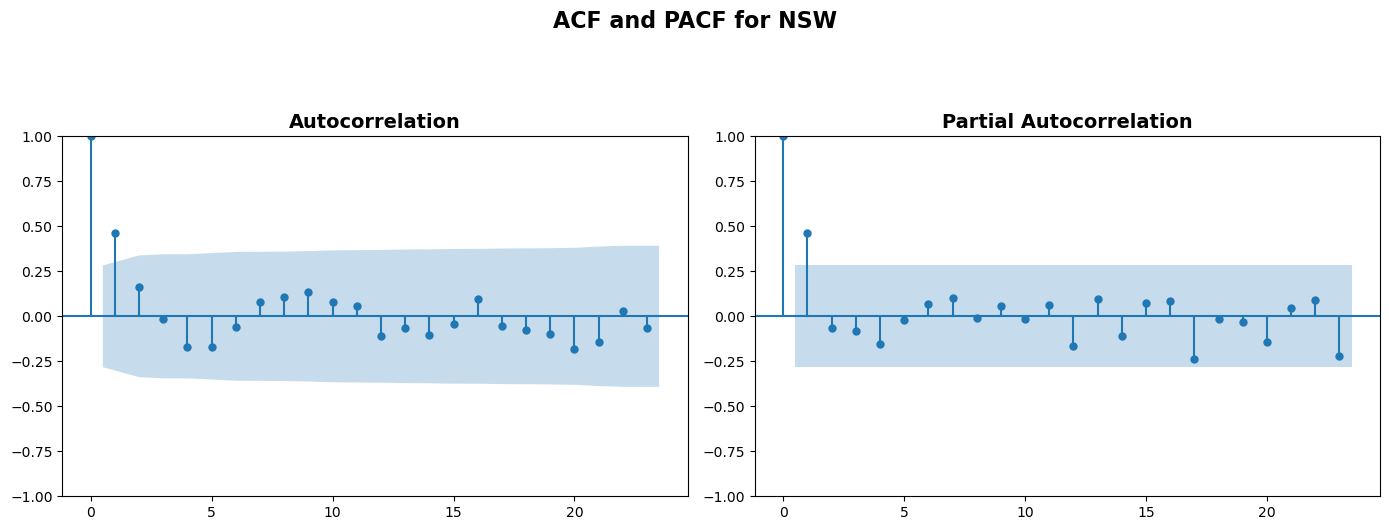

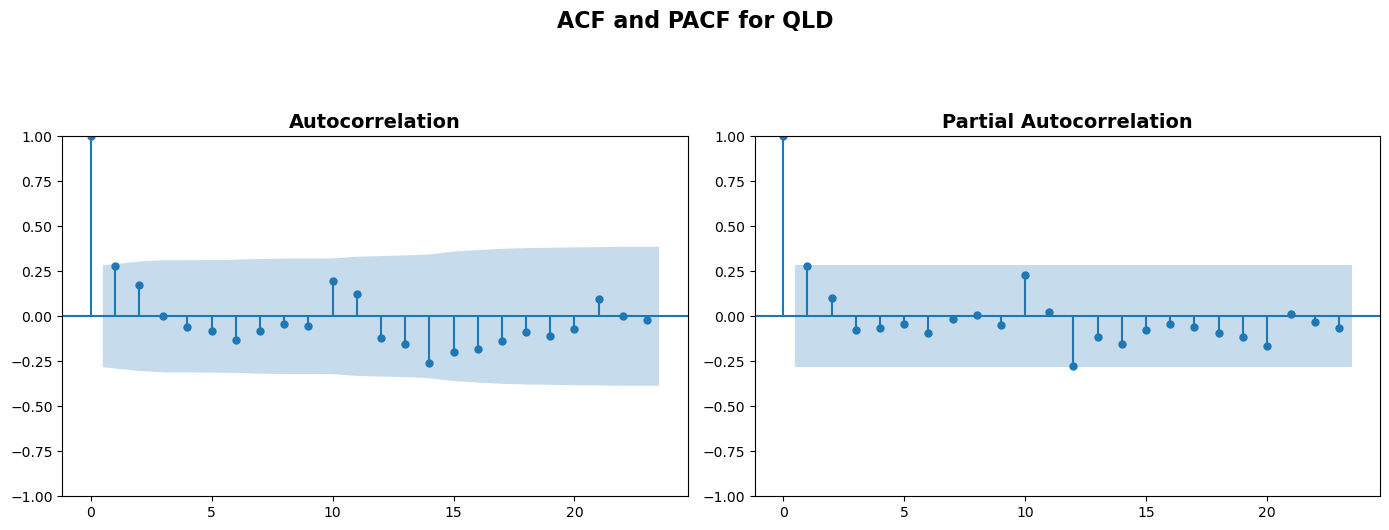

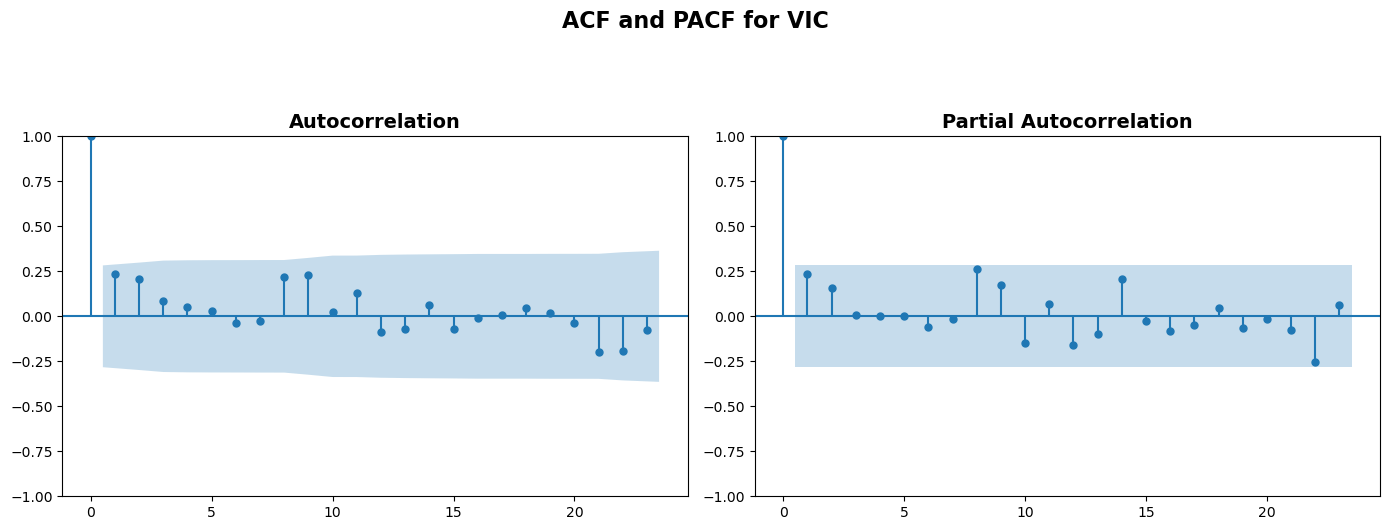

In [83]:
diff_list = {'NSW': NSW_diff, 'QLD': QLD_diff, 'VIC': VIC_diff}

for name, series in diff_list.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    
    # ACF
    sm.graphics.tsa.plot_acf(series, lags=23, alpha=0.05, ax=ax1)
    ax1.set_title("Autocorrelation", fontsize=14, fontweight="bold")
    
    # PACF
    sm.graphics.tsa.plot_pacf(series, lags=23, alpha=0.05, ax=ax2, method="ywm")
    ax2.set_title("Partial Autocorrelation", fontsize=14, fontweight="bold")
    
    fig.suptitle(f"ACF and PACF for {name}", fontsize=16, fontweight="bold", y=1.05)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

# Modelling

In [84]:
'''TODO: determine the goal of modelling. Some ideas in mind: 
- Aggregate the states and predict the total demand for all states
- Use multivariate time series models to capture interdependencies between states
- Deploy advanced models like LSTM for potentially better performance


- add feature engineering using weather data (temperature, humidity, wind speed, etc.) to improve model accuracy
- multivariate modelling using VAR, RandomForest, etc.
'''

'TODO: determine the goal of modelling. Some ideas in mind: \n- Aggregate the states and predict the total demand for all states\n- Use multivariate time series models to capture interdependencies between states\n- Deploy advanced models like LSTM for potentially better performance\n\n\n- add feature engineering using weather data (temperature, humidity, wind speed, etc.) to improve model accuracy\n- multivariate modelling using VAR, RandomForest, etc.\n'

## Seasonal Random Walk

In [85]:
season_length = 12  # monthly data with yearly seasonality
seasonal_rw_df = pd.DataFrame(index=NSW_test.index)

for name, series in zip(['NSW', 'QLD', 'VIC'], [NSW_train, QLD_train, VIC_train]):
    history = series.dropna()
    forecast = []

    for h in range(1, len(NSW_test) + 1): 
        k = ((h - 1) // season_length) + 1
        index = -season_length * k

        if abs(index) >= len(history):
            yhat = history.iloc[-1] # fallback to last observation
        else: 
            yhat = history.iloc[index]

        forecast.append(yhat)

    seasonal_rw_df[name] = forecast

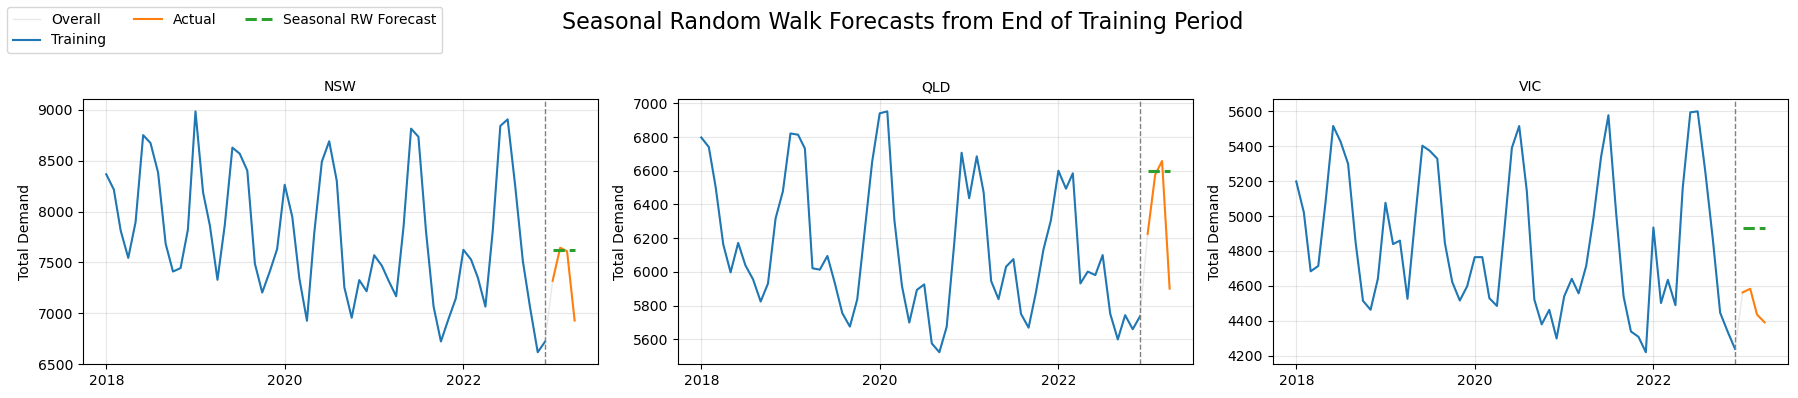

In [86]:
test_list = {'NSW': NSW_test, 'QLD': QLD_test, 'VIC': VIC_test}
import matplotlib.dates as mdates

# dicts of Series (same keys): train_list, test_list
# DataFrame of forecasts with columns matching the keys: seasonal_rw_df
forecast_model_df_seasonal = seasonal_rw_df

names = list(train_list.keys())            # ['NSW','QLD','VIC']
n_cols = 3
n_rows = int(np.ceil(len(names) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True)
axes = np.atleast_1d(axes).ravel()

def idx_to_ts(s):
    idx = s.index
    return idx.to_timestamp() if hasattr(idx, 'to_timestamp') else idx

for i, name in enumerate(names):
    ax = axes[i]

    tr = train_list[name]                       # Series
    te = test_list[name]                        # Series
    fc = forecast_model_df_seasonal[name]       # Series or DataFrame column

    # X values (handle PeriodIndex or DatetimeIndex)
    x_tr = idx_to_ts(tr)
    x_te = idx_to_ts(te)
    x_fc = idx_to_ts(fc)
    
    combined = pd.concat([tr, te])
    ax.plot(combined.index, combined.values, color='lightgray', alpha=0.5, label='Overall', lw=1)

    ax.plot(x_tr, tr.values, label='Training', color='#1f77b4', lw=1.5)
    ax.plot(x_te, te.values, label='Actual',   color='#ff7f0e', lw=1.5)
    ax.plot(x_fc, fc.values, label='Seasonal RW Forecast',
            color='#2ca02c', lw=2.2, ls='--')

    # vertical split marker at end of training
    ax.axvline(x_tr[-1], color='gray', ls='--', lw=1)

    ax.set_title(name, fontsize=10)
    ax.set_ylabel('Total Demand')
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# global legend and title
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=3, fontsize=10)
fig.suptitle("Seasonal Random Walk Forecasts from End of Training Period", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

In [87]:
import numpy as np
import pandas as pd

def mae(a, b): 
    a = np.asarray(a); b = np.asarray(b)
    return np.mean(np.abs(a - b))

def rmse(a, b): 
    a = np.asarray(a); b = np.asarray(b)
    return np.sqrt(np.mean((a - b) ** 2))

def mape(a, b):  # safer MAPE (avoid div-by-zero)
    a = np.asarray(a); b = np.asarray(b)
    denom = np.where(a == 0, 1e-9, np.abs(a))
    return np.mean(np.abs((a - b) / denom)) * 100

results = pd.DataFrame(columns=['Region', 'MAE', 'RMSE', 'MAPE', 'N'])

# accumulators for MICRO/pooled metrics
sse_total = 0.0
abs_err_total = 0.0
abs_pct_err_total = 0.0
n_total = 0

for name in names:
    tr = train_list[name]                 # Series
    te = test_list[name]                  # Series
    fc = forecast_model_df_seasonal[name] # Series or single-col DataFrame

    # ensure forecast is a 1D Series
    if isinstance(fc, pd.DataFrame):
        fc = fc.iloc[:, 0]

    # align to common test index
    common_index = te.index.intersection(fc.index)
    te_aligned = te.loc[common_index]
    fc_aligned = fc.loc[common_index]

    # per-region metrics
    mae_value  = mae(te_aligned.values,  fc_aligned.values)
    rmse_value = rmse(te_aligned.values, fc_aligned.values)
    mape_value = mape(te_aligned.values, fc_aligned.values)
    n_i = len(common_index)

    results = pd.concat([results, pd.DataFrame({
        'Region': [name],
        'MAE': [mae_value],
        'RMSE': [rmse_value],
        'MAPE': [mape_value],
        'N': [n_i]
    })], ignore_index=True)

    # update pooled accumulators
    diff = te_aligned.values - fc_aligned.values
    sse_total += np.sum(diff**2)
    abs_err_total += np.sum(np.abs(diff))
    abs_pct_err_total += np.sum(np.abs(diff) / np.where(te_aligned.values==0, 1e-9, np.abs(te_aligned.values)))
    n_total += n_i

# sort and show per-region
print('HW Seasonal RW')
results = results.sort_values('RMSE')
print(results[['Region','MAE','RMSE','MAPE','N']])

# --- OVERALL metrics ---
# Macro (each region weighs the same)
overall_rmse_macro = results['RMSE'].mean()
overall_mae_macro  = results['MAE'].mean()
overall_mape_macro = results['MAPE'].mean()

# Micro / pooled (each observation weighs the same)
overall_rmse_micro = np.sqrt(sse_total / n_total)
overall_mae_micro  = abs_err_total / n_total
overall_mape_micro = (abs_pct_err_total / n_total) * 100

print(f"\nOverall RMSE (macro avg): {overall_rmse_macro:.3f}")
print(f"Overall RMSE (micro/pooled): {overall_rmse_micro:.3f}")
print(f"Overall MAE  (micro/pooled): {overall_mae_micro:.3f}")
print(f"Overall MAPE (micro/pooled): {overall_mape_micro:.3f}%")

HW Seasonal RW
  Region         MAE        RMSE      MAPE  N
0    NSW  258.501897  379.735777  3.660988  4
1    QLD  288.912953  398.256016  4.775850  4
2    VIC  440.770435  448.267706  9.845847  4

Overall RMSE (macro avg): 408.753
Overall RMSE (micro/pooled): 409.777
Overall MAE  (micro/pooled): 329.395
Overall MAPE (micro/pooled): 6.094%


## Holt Winter's Additive Model

In [88]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
hw_add = pd.DataFrame(index=NSW_test.index)

for name, series in zip(['NSW', 'QLD', 'VIC'], [NSW_train, QLD_train, VIC_train]):
    model = ExponentialSmoothing(series, seasonal='add', seasonal_periods=12, initialization_method='estimated').fit()

    hw_add[name] = model.forecast(len(series))

forecast_model_df_hw_add = hw_add.copy()

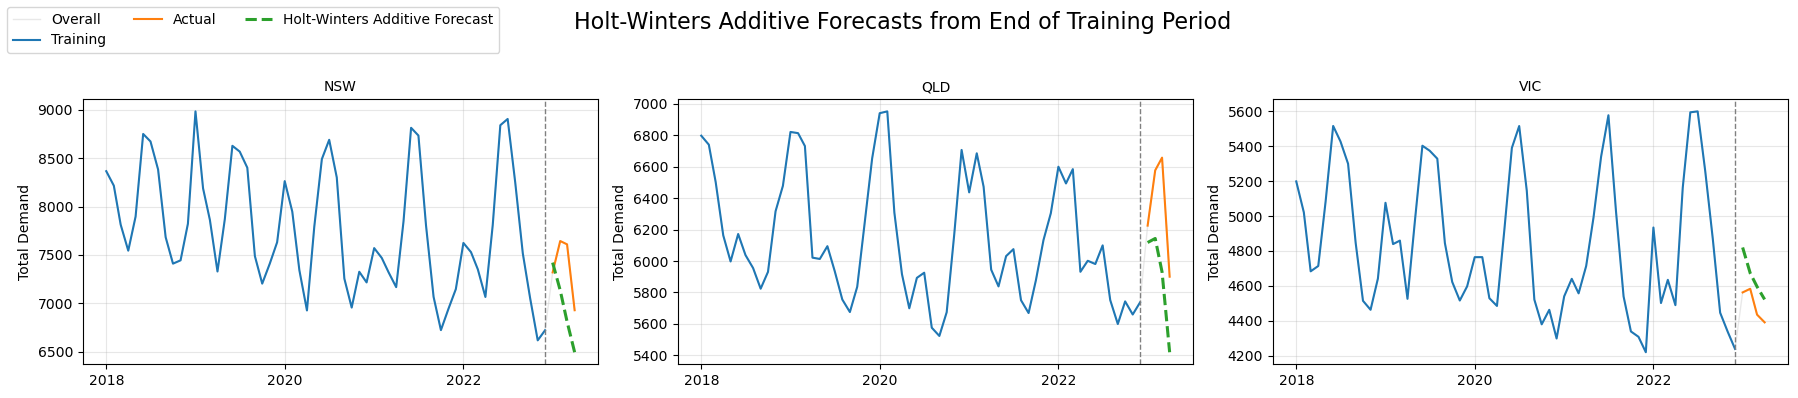

In [89]:
names = list(train_list.keys())            # ['NSW','QLD','VIC']
n_cols = 3
n_rows = int(np.ceil(len(names) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True)
axes = np.atleast_1d(axes).ravel()

for i, name in enumerate(names):
    ax = axes[i]

    tr = train_list[name]                       # Series
    te = test_list[name]                        # Series
    fc = forecast_model_df_hw_add[name]       # Series or DataFrame column

    # X values (handle PeriodIndex or DatetimeIndex)
    x_tr = idx_to_ts(tr)
    x_te = idx_to_ts(te)
    x_fc = idx_to_ts(fc)
    
    combined = pd.concat([tr, te])
    ax.plot(combined.index, combined.values, color='lightgray', alpha=0.5, label='Overall', lw=1)

    ax.plot(x_tr, tr.values, label='Training', color='#1f77b4', lw=1.5)
    ax.plot(x_te, te.values, label='Actual',   color='#ff7f0e', lw=1.5)
    ax.plot(x_fc, fc.values, label='Holt-Winters Additive Forecast',
            color='#2ca02c', lw=2.2, ls='--')

    # vertical split marker at end of training
    ax.axvline(x_tr[-1], color='gray', ls='--', lw=1)

    ax.set_title(name, fontsize=10)
    ax.set_ylabel('Total Demand')
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# global legend and title
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=3, fontsize=10)
fig.suptitle("Holt-Winters Additive Forecasts from End of Training Period", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

In [90]:
results_hw_add = pd.DataFrame(columns=['Region', 'MAE', 'RMSE', 'MAPE'])

def idx_to_ts(s):
    idx = s.index
    return idx.to_timestamp() if hasattr(idx, 'to_timestamp') else idx

for i, name in enumerate(names):

    tr = train_list[name]                       # Series
    te = test_list[name]                        # Series
    fc = forecast_model_df_hw_add[name]       # Series or DataFrame column
    
    # Ensure test and forecast data align for error metrics
    common_index = te.index.intersection(fc.index)
    te_aligned = te.loc[common_index]
    fc_aligned = fc.loc[common_index]
    
    # Calculate error metrics
    mae_value = mae(te_aligned.values, fc_aligned.values)
    rmse_value = rmse(te_aligned.values, fc_aligned.values)
    mape_value = mape(te_aligned.values, fc_aligned.values)
    
    # Append to results DataFrame
    results_hw_add = pd.concat([results_hw_add, pd.DataFrame({
        'Region': [name],
        'MAE': [mae_value],
        'RMSE': [rmse_value],
        'MAPE': [mape_value]
    })], ignore_index=True)

# Display results_hw_add sorted by RMSE
print('HW Seasonal Additive')
results_hw_add = results_hw_add.sort_values('RMSE')
print(results_hw_add)

HW Seasonal Additive
  Region         MAE        RMSE      MAPE
2    VIC  159.485715  171.016886  3.546392
1    QLD  437.519861  490.104733  6.851392
0    NSW  460.859049  523.397003  6.202280


In [125]:
# --- OVERALL metrics ---
sse_total_hwadd = 0.0
abs_err_total_hwadd = 0.0
abs_pct_err_total_hwadd = 0.0
n_total_hwadd = 0

for name in names:
    tr = train_list[name]                 # Series
    te = test_list[name]                  # Series
    fc = forecast_model_df_hw_add[name] # Series or single-col DataFrame

    # ensure forecast is a 1D Series
    if isinstance(fc, pd.DataFrame):
        fc = fc.iloc[:, 0]

    # align to common test index
    common_index = te.index.intersection(fc.index)
    te_aligned = te.loc[common_index]
    fc_aligned = fc.loc[common_index]

    # per-region metrics
    mae_value  = mae(te_aligned.values,  fc_aligned.values)
    rmse_value = rmse(te_aligned.values, fc_aligned.values)
    mape_value = mape(te_aligned.values, fc_aligned.values)
    n_i = len(common_index)

    results = pd.concat([results, pd.DataFrame({
        'Region': [name],
        'MAE': [mae_value],
        'RMSE': [rmse_value],
        'MAPE': [mape_value],
        'N': [n_i]
    })], ignore_index=True)

    # update pooled accumulators
    diff = te_aligned.values - fc_aligned.values
    sse_total_hwadd += np.sum(diff**2)
    abs_err_total_hwadd += np.sum(np.abs(diff))
    abs_pct_err_total_hwadd += np.sum(np.abs(diff) / np.where(te_aligned.values==0, 1e-9, np.abs(te_aligned.values)))
    n_total_hwadd += n_i

# sort and show per-region
print('HW Seasonal Additive')
results = results.sort_values('RMSE')
print(results[['Region','MAE','RMSE','MAPE','N']])

# --- OVERALL metrics ---
# Macro (each region weighs the same)
overall_rmse_macro_hwadd = results['RMSE'].mean()
overall_mae_macro_hwadd  = results['MAE'].mean()
overall_mape_macro_hwadd = results['MAPE'].mean()

# Micro / pooled (each observation weighs the same)
overall_rmse_micro_hwadd = np.sqrt(sse_total_hwadd / n_total_hwadd)
overall_mae_micro_hwadd  = abs_err_total_hwadd / n_total_hwadd
overall_mape_micro_hwadd = (abs_pct_err_total_hwadd / n_total_hwadd) * 100

print(f"\nOverall RMSE (macro avg): {overall_rmse_macro_hwadd:.3f}")
print(f"Overall RMSE (micro/pooled): {overall_rmse_micro_hwadd:.3f}")
print(f"Overall MAE  (micro/pooled): {overall_mae_micro_hwadd:.3f}")
print(f"Overall MAPE (micro/pooled): {overall_mape_micro_hwadd:.3f}%")

HW Seasonal Additive
  Region         MAE        RMSE      MAPE  N
0    VIC  159.485715  171.016886  3.546392  4
8    VIC  159.485715  171.016886  3.546392  4
1    NSW  258.501897  379.735777  3.660988  4
2    QLD  288.912953  398.256016  4.775850  4
3    VIC  440.770435  448.267706  9.845847  4
4    QLD  437.519861  490.104733  6.851392  4
7    QLD  437.519861  490.104733  6.851392  4
5    NSW  460.859049  523.397003  6.202280  4
6    NSW  460.859049  523.397003  6.202280  4

Overall RMSE (macro avg): 399.477
Overall RMSE (micro/pooled): 425.595
Overall MAE  (micro/pooled): 352.622
Overall MAPE (micro/pooled): 5.533%


## Damped HW

In [91]:
holt_damped_df = pd.DataFrame(index=NSW_test.index)

# The number of periods to forecast is the length of the test set index
forecast_horizon = len(NSW_test.index)

for name, series in train_list.items():
    # Add trend='add' to specify the trend component to be dampened
    model = ExponentialSmoothing(
        series,
        trend='add',
        damped_trend=True,
        seasonal='add',
        seasonal_periods=12,
        initialization_method='estimated'
    ).fit()
    
    # Forecast for the length of the test set, not the training set
    forecast_values = model.forecast(forecast_horizon)
    
    # Ensure the forecast index matches the destination DataFrame index
    forecast_values.index = holt_damped_df.index
    
    holt_damped_df[name] = forecast_values

fc_model_hw_add_damped = holt_damped_df.copy()

# print(fc_model_hw_add_damped.head())

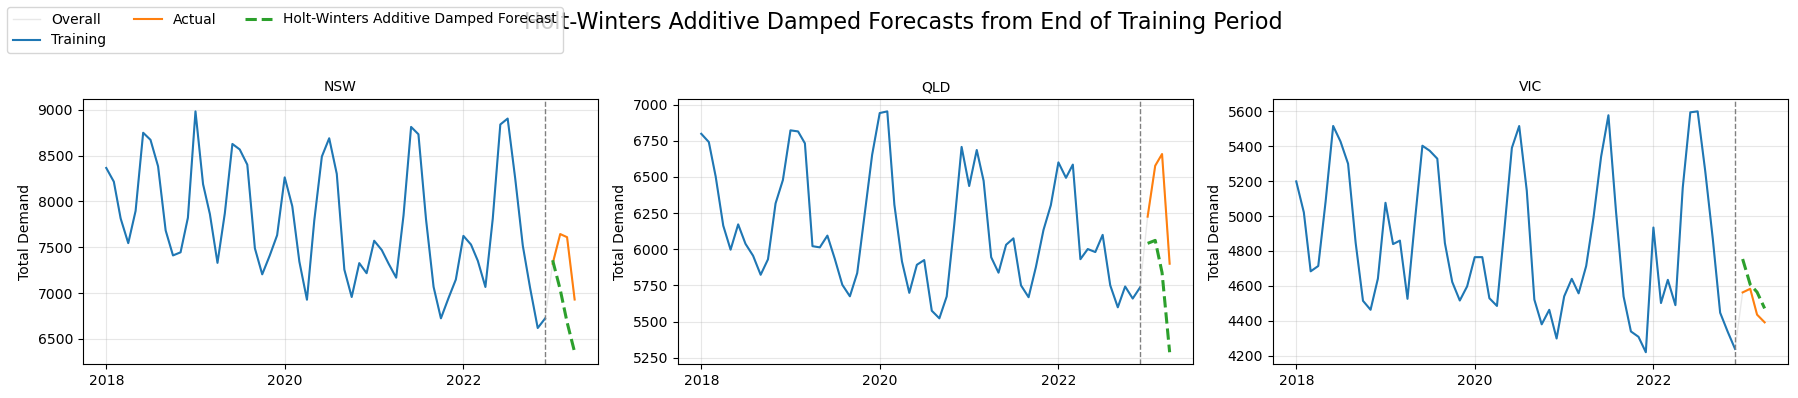

In [92]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True)
axes = np.atleast_1d(axes).ravel()

for i, name in enumerate(names):
    ax = axes[i]

    tr = train_list[name]                       # Series
    te = test_list[name]                        # Series
    fc = fc_model_hw_add_damped[name]       # Series or DataFrame column

    # X values (handle PeriodIndex or DatetimeIndex)
    x_tr = idx_to_ts(tr)
    x_te = idx_to_ts(te)
    x_fc = idx_to_ts(fc)
    
    combined = pd.concat([tr, te])
    ax.plot(combined.index, combined.values, color='lightgray', alpha=0.5, label='Overall', lw=1)

    ax.plot(x_tr, tr.values, label='Training', color='#1f77b4', lw=1.5)
    ax.plot(x_te, te.values, label='Actual',   color='#ff7f0e', lw=1.5)
    ax.plot(x_fc, fc.values, label='Holt-Winters Additive Damped Forecast',
            color='#2ca02c', lw=2.2, ls='--')

    # vertical split marker at end of training
    ax.axvline(x_tr[-1], color='gray', ls='--', lw=1)

    ax.set_title(name, fontsize=10)
    ax.set_ylabel('Total Demand')
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# global legend and title
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=3, fontsize=10)
fig.suptitle("Holt-Winters Additive Damped Forecasts from End of Training Period", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

In [93]:
result_hwadd_damped = pd.DataFrame(columns=['Region', 'MAE', 'RMSE', 'MAPE'])

def idx_to_ts(s):
    idx = s.index
    return idx.to_timestamp() if hasattr(idx, 'to_timestamp') else idx

for i, name in enumerate(names):

    tr = train_list[name]                       # Series
    te = test_list[name]                        # Series
    fc = fc_model_hw_add_damped[name]       # Series or DataFrame column
    
    # Ensure test and forecast data align for error metrics
    common_index = te.index.intersection(fc.index)
    te_aligned = te.loc[common_index]
    fc_aligned = fc.loc[common_index]
    
    # Calculate error metrics
    mae_value = mae(te_aligned.values, fc_aligned.values)
    rmse_value = rmse(te_aligned.values, fc_aligned.values)
    mape_value = mape(te_aligned.values, fc_aligned.values)
    
    # Append to results DataFrame
    result_hwadd_damped = pd.concat([result_hwadd_damped, pd.DataFrame({
        'Region': [name],
        'MAE': [mae_value],
        'RMSE': [rmse_value],
        'MAPE': [mape_value]
    })], ignore_index=True)

# Display result_hwadd_damped sorted by RMSE
print('HW Seasonal Additive Damped')
result_hwadd_damped = result_hwadd_damped.sort_values('RMSE')
print(result_hwadd_damped)

HW Seasonal Additive Damped
  Region         MAE        RMSE      MAPE
2    VIC  106.069715  122.566388  2.361425
1    QLD  532.783999  579.930868  8.369065
0    NSW  537.346490  625.075226  7.243605


In [126]:
# --- OVERALL metrics ---
sse_total_hwadd_damped = 0.0
abs_err_total_hwadd_damped = 0.0
abs_pct_err_total_hwadd_damped = 0.0
n_total_hwadd_damped = 0

for name in names:
    tr = train_list[name]                 # Series
    te = test_list[name]                  # Series
    fc = fc_model_hw_add_damped[name] # Series or single-col DataFrame

    # ensure forecast is a 1D Series
    if isinstance(fc, pd.DataFrame):
        fc = fc.iloc[:, 0]

    # align to common test index
    common_index = te.index.intersection(fc.index)
    te_aligned = te.loc[common_index]
    fc_aligned = fc.loc[common_index]

    # per-region metrics
    mae_value  = mae(te_aligned.values,  fc_aligned.values)
    rmse_value = rmse(te_aligned.values, fc_aligned.values)
    mape_value = mape(te_aligned.values, fc_aligned.values)
    n_i = len(common_index)

    results = pd.concat([results, pd.DataFrame({
        'Region': [name],
        'MAE': [mae_value],
        'RMSE': [rmse_value],
        'MAPE': [mape_value],
        'N': [n_i]
    })], ignore_index=True)

    # update pooled accumulators
    diff = te_aligned.values - fc_aligned.values
    sse_total_hwadd_damped += np.sum(diff**2)
    abs_err_total_hwadd_damped += np.sum(np.abs(diff))
    abs_pct_err_total_hwadd_damped += np.sum(np.abs(diff) / np.where(te_aligned.values==0, 1e-9, np.abs(te_aligned.values)))
    n_total_hwadd_damped += n_i

# sort and show per-region
print('HW Seasonal Additive')
results = results.sort_values('RMSE')
print(results[['Region','MAE','RMSE','MAPE','N']])

# --- OVERALL metrics ---
# Macro (each region weighs the same)
overall_rmse_macro_hwadd_damped = results['RMSE'].mean()
overall_mae_macro_hwadd_damped  = results['MAE'].mean()
overall_mape_macro_hwadd_damped = results['MAPE'].mean()

# Micro / pooled (each observation weighs the same)
overall_rmse_micro_hwadd_damped = np.sqrt(sse_total_hwadd_damped / n_total_hwadd_damped)
overall_mae_micro_hwadd_damped  = abs_err_total_hwadd_damped / n_total_hwadd_damped
overall_mape_micro_hwadd_damped = (abs_pct_err_total_hwadd_damped / n_total_hwadd_damped) * 100

print(f"\nOverall RMSE (macro avg): {overall_rmse_macro_hwadd_damped:.3f}")
print(f"Overall RMSE (micro/pooled): {overall_rmse_micro_hwadd_damped:.3f}")
print(f"Overall MAE  (micro/pooled): {overall_mae_micro_hwadd_damped:.3f}")
print(f"Overall MAPE (micro/pooled): {overall_mape_micro_hwadd_damped:.3f}%")

HW Seasonal Additive
   Region         MAE        RMSE      MAPE  N
11    VIC  106.069715  122.566388  2.361425  4
0     VIC  159.485715  171.016886  3.546392  4
1     VIC  159.485715  171.016886  3.546392  4
2     NSW  258.501897  379.735777  3.660988  4
3     QLD  288.912953  398.256016  4.775850  4
4     VIC  440.770435  448.267706  9.845847  4
5     QLD  437.519861  490.104733  6.851392  4
6     QLD  437.519861  490.104733  6.851392  4
7     NSW  460.859049  523.397003  6.202280  4
8     NSW  460.859049  523.397003  6.202280  4
10    QLD  532.783999  579.930868  8.369065  4
9     NSW  537.346490  625.075226  7.243605  4

Overall RMSE (macro avg): 410.239
Overall RMSE (micro/pooled): 497.347
Overall MAE  (micro/pooled): 392.067
Overall MAPE (micro/pooled): 5.991%


## SARIMA Model

In [94]:
def sarima_order_select(ts,
                            p_range=range(0, 3), d_range=[1], q_range=range(0, 3),
                            P_range=range(0, 2), D_range=[1], Q_range=range(0, 2),
                            s=12, max_attempts=None, criteria = "aic"):
    """
    Grid search for the best SARIMA order based on AIC.

    Parameters:
        ts (pd.Series): Time series data
        p,d,q: Non-seasonal ARIMA parameters
        P,D,Q,s: Seasonal SARIMA parameters
        max_attempts (int): Limit number of combinations tested (for speed/debug)

    Returns:
        dict: {'order': (p,d,q), 'seasonal_order': (P,D,Q,s), 'aic': aic_value}
    """
    best_score = float("inf")
    best_order = None
    best_seasonal = None
    attempts = 0

    for order in tqdm(itertools.product(p_range, d_range, q_range)):
        for seasonal in itertools.product(P_range, D_range, Q_range):
            seasonal_order = (seasonal[0], seasonal[1], seasonal[2], s)
            try:
                model = SARIMAX(ts, order=order, seasonal_order=seasonal_order, enforce_stationarity=True, enforce_invertibility=True)
                results = model.fit(disp=False)
                if criteria == "bic":
                    score = results.bic
                elif criteria == "aic":
                    score = results.aic
                if score < best_score:
                    best_score = score
                    best_order = order
                    best_seasonal = seasonal_order
            except Exception as e:
                continue
            attempts += 1
            if max_attempts and attempts >= max_attempts:
                break

    return {
        'order': best_order,
        'seasonal_order': best_seasonal,
        'score': best_score
    }

In [95]:
sarima_simp_order_result = []

for name, series in train_list.items():
    params = {"variable" : name}
    params.update(sarima_order_select(
        ts=series,  # your stationary or differenced seasonal series
        p_range=range(0, 4),
        d_range=[1],
        q_range=range(0, 4),
        P_range=range(0, 1),
        D_range=[1],
        Q_range=range(0, 1),
        s=12  # or 4 if quarterly, etc.
    ))
    sarima_simp_order_result.append(params)

sarima_simp_order_result = pd.DataFrame(sarima_simp_order_result)

16it [00:02,  5.98it/s]
16it [00:02,  6.16it/s]
16it [00:02,  7.52it/s]


In [96]:
sarima_simp_order_result

,variable,order,seasonal_order,score
0,NSW,"(3, 1, 3)","(0, 1, 0, 12)",658.268472
1,QLD,"(0, 1, 1)","(0, 1, 0, 12)",634.649813
2,VIC,"(0, 1, 1)","(0, 1, 0, 12)",617.364230


In [97]:
opt = sarima_simp_order_result.copy()

def forecast_series(y_train: pd.Series, y_test: pd.Series, order, seasonal_order):
    '''Fit on y_train, forecast len(y_test), return pred series aligned to y_test index and sf (intervals).'''
    model = SARIMAX(
        y_train, order=order, seasonal_order=seasonal_order,
        enforce_stationarity=False, enforce_invertibility=False
    )
    res = model.fit(disp=False)
    fc = res.get_forecast(steps=len(y_test))
    sf = fc.summary_frame()  # columns: mean, mean_se, mean_ci_lower, mean_ci_upper
    yhat = pd.Series(sf['mean'].values, index=y_test.index, name=y_train.name)
    return yhat, sf

preds = {}
intervals = {}
rows = []

for name in ["NSW","QLD","VIC"]:
    row = opt.loc[opt["variable"].eq(name)].iloc[0]
    order, seasonal_order = tuple(row["order"]), tuple(row["seasonal_order"])

    yhat, sf = forecast_series(train_list[name], test_list[name], order, seasonal_order)
    preds[name] = yhat
    intervals[name] = sf.set_index(yhat.index)  # for plotting later

    mae  = mean_absolute_error(test_list[name], yhat)
    rmse = root_mean_squared_error(test_list[name], yhat)
    rows.append({"series": name, "order": order, "seasonal_order": seasonal_order,
                 "test_len": len(yhat), "MAE": mae, "RMSE": rmse})

metrics = pd.DataFrame(rows).set_index("series").sort_index()
pred_df = pd.concat(preds, axis=1)  # columns: NSW, QLD, VIC (indexed by test dates)

print(metrics)

            order seasonal_order  test_len         MAE        RMSE
series                                                            
NSW     (3, 1, 3)  (0, 1, 0, 12)         4  188.199177  199.666045
QLD     (0, 1, 1)  (0, 1, 0, 12)         4  327.954920  377.005879
VIC     (0, 1, 1)  (0, 1, 0, 12)         4  232.612314  284.663480


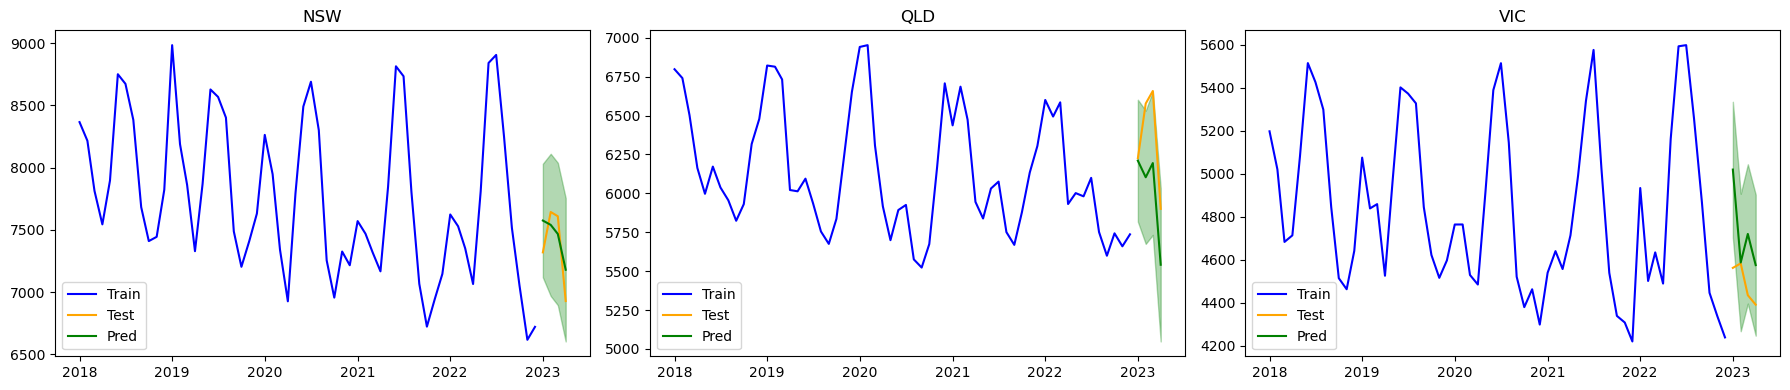

In [98]:
# plot forecasts from SARIMA
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True)

for i, name in enumerate(["NSW", "QLD", "VIC"]):
    ax = axes[i]
    ax.plot(train_list[name].index, train_list[name], label='Train', color='blue')
    ax.plot(test_list[name].index, test_list[name], label='Test', color='orange')
    ax.plot(preds[name].index, preds[name], label='Pred', color='green')
    ax.fill_between(intervals[name].index, intervals[name]['mean_ci_lower'], intervals[name]['mean_ci_upper'], color='green', alpha=0.3)
    ax.set_title(name)
    ax.legend()

plt.tight_layout()
plt.show()

In [99]:
def walk_forward(y_train, y_test, order, seasonal_order):
    history = y_train.copy()
    means, lowers, uppers = [], [], []

    for t in range(len(y_test)):
        model = SARIMAX(history, order=order, seasonal_order=seasonal_order,
                        enforce_stationarity=True, enforce_invertibility=True)
        res = model.fit(disp=False)
        fc = res.get_forecast(1)
        sf = fc.summary_frame()

        means.append(sf['mean'].values[0])
        lowers.append(sf['mean_ci_lower'].values[0])
        uppers.append(sf['mean_ci_upper'].values[0])
        
        history = pd.concat([history, y_test.iloc[[t]]])
        
    return pd.DataFrame(
        {"mean": means, "lower": lowers, "upper": uppers},
        index=y_test.index
    )

In [100]:
preds_roll = {}
intervals_roll = {}
rows_roll = []

for name in ["NSW","QLD","VIC"]:
    row = opt.loc[opt["variable"].eq(name)].iloc[0]
    order, seasonal_order = tuple(row["order"]), tuple(row["seasonal_order"])

    # If your function returns a DF with ['mean','lower','upper'], keep both:
    yhat_df = walk_forward(train_list[name], test_list[name], order, seasonal_order)
    yhat_mean = yhat_df["mean"].astype(float)

    preds_roll[name]     = yhat_mean                   # for metrics/plots of the mean
    intervals_roll[name] = yhat_df[["lower","upper"]]  # for shaded PIs

    # Align just in case (and ensure numeric)
    y_true = test_list[name].reindex(yhat_mean.index).astype(float)

    mae  = mean_absolute_error(y_true, yhat_mean)
    rmse = root_mean_squared_error(y_true, yhat_mean)

    rows_roll.append({
        "series": name, "order": order, "seasonal_order": seasonal_order,
        "test_len": len(yhat_mean), "MAE": mae, "RMSE": rmse
    })

metrics_roll = pd.DataFrame(rows_roll).set_index("series").sort_index()
pred_df_roll = pd.concat(preds_roll, axis=1)  # columns: NSW, QLD, VIC
print(metrics_roll)

            order seasonal_order  test_len         MAE        RMSE
series                                                            
NSW     (3, 1, 3)  (0, 1, 0, 12)         4  247.174922  307.206747
QLD     (0, 1, 1)  (0, 1, 0, 12)         4  205.928321  272.082522
VIC     (0, 1, 1)  (0, 1, 0, 12)         4  210.439756  260.708227


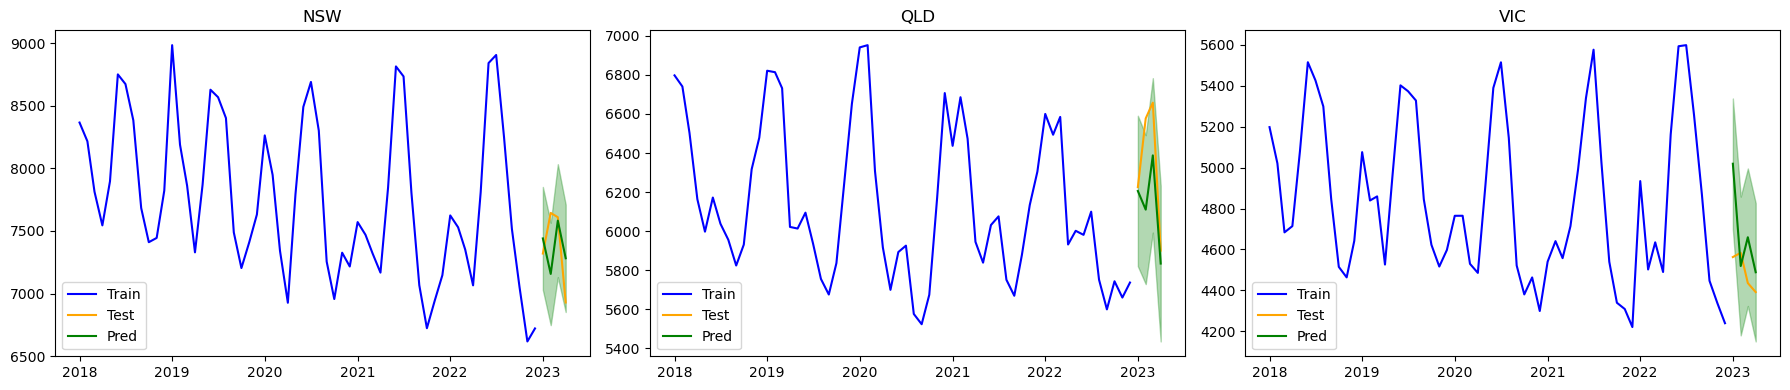

In [101]:
# plot forecasts from SARIMA
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True)

for i, name in enumerate(["NSW", "QLD", "VIC"]):
    ax = axes[i]
    ax.plot(train_list[name].index, train_list[name], label='Train', color='blue')
    ax.plot(test_list[name].index, test_list[name], label='Test', color='orange')
    ax.plot(preds_roll[name].index, preds_roll[name], label='Pred', color='green')
    ax.fill_between(intervals_roll[name].index, intervals_roll[name]['lower'], intervals_roll[name]['upper'], color='green', alpha=0.3)
    ax.set_title(name)
    ax.legend()

plt.tight_layout()
plt.show()

# Multivariate models

In [102]:
import holidays

''' 
Adding time related features to monthly data
- Year      
- Month
- Quarter
- Season
- Days in month
- Holiday count (state specific)
- Holiday share (holidays / days in month)
- Time index (t)
- Fourier terms (K pairs for annual cycle): sin,cos, sin2, cos2, sin3, cos3
'''
# Seasons by month (AU)
map_month_to_season = {
    12:'summer', 1:'summer', 2:'summer',
    3:'autumn', 4:'autumn', 5:'autumn',
    6:'winter', 7:'winter', 8:'winter',
    9:'spring', 10:'spring', 11:'spring'
}

datasets = [("NSW", NSW_data), ("QLD", QLD_data), ("VIC", VIC_data)]

K = 3       # number of Fourier pairs for annual cycle (tune 2–6)
P = 12      # period (months in a year)

for state, df in datasets:
    # ensure datetime & sort
    df["SETTLEMENTDATE"] = pd.to_datetime(df["SETTLEMENTDATE"])
    df.sort_values("SETTLEMENTDATE", inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Year/Month/Quarter/Season
    ts = df["SETTLEMENTDATE"]
    df["Year"]    = ts.dt.year
    df["Month"]   = ts.dt.month
    df["Quarter"] = ts.dt.quarter
    df["Season"]  = pd.Categorical(
        df["Month"].map(map_month_to_season),
        categories=["summer","autumn","winter","spring"], ordered=True
    )

    # Month length
    df["DaysInMonth"] = ts.dt.days_in_month

    # State holidays: count per month (+ share)
    years = range(int(df["Year"].min()), int(df["Year"].max()) + 1)
    hol = holidays.Australia(subdiv=state, years=years)  # new param name

    hol_month = (
        pd.Series(1, index=pd.to_datetime(list(hol.keys())))
          .to_frame("is_hol")
          .assign(ym=lambda s: s.index.to_period("M"))
          .groupby("ym")["is_hol"].sum()
    )

    df["ym"] = ts.dt.to_period("M")
    df["HolidayCount"]  = df["ym"].map(hol_month).fillna(0).astype(int)
    df["HolidayShare"]  = df["HolidayCount"] / df["DaysInMonth"]

    # Time index + Fourier terms (annual seasonality)
    df["t"] = np.arange(len(df), dtype=float)
    for k in range(1, K+1):
        df[f"sin{k}"] = np.sin(2*np.pi*k*df["t"]/P)
        df[f"cos{k}"] = np.cos(2*np.pi*k*df["t"]/P)

    # Drop features that don't make sense for monthly data if they exist
    drop_cols = ["Hour","Minute","Weekday","Weekend","Time","HOD48",
                 "sin_d","cos_d","sin_w","cos_w"]
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors="ignore")
    df.drop(columns=["ym"], inplace=True)

    print(f"{state} monthly features ready. Sample:")
    print(df.info())
    print()

NSW monthly features ready. Sample:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248592 entries, 0 to 248591
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   REGION          248592 non-null  object        
 1   SETTLEMENTDATE  248592 non-null  datetime64[ns]
 2   TOTALDEMAND     248592 non-null  float64       
 3   RRP             248592 non-null  object        
 4   PERIODTYPE      248592 non-null  object        
 5   Year            248592 non-null  int32         
 6   Month           248592 non-null  int32         
 7   Quarter         248592 non-null  int32         
 8   Season          248592 non-null  category      
 9   DaysInMonth     248592 non-null  int32         
 10  HolidayCount    248592 non-null  int32         
 11  HolidayShare    248592 non-null  float64       
 12  t               248592 non-null  float64       
 13  sin1            248592 non-null  float64       
 14  

In [103]:
# -------- Build monthly weather from `weather_data` --------
wd = weather_data.copy()
wd["date"] = pd.to_datetime(wd["YYYY-MM-DD"], errors="coerce")
wd = wd.dropna(subset=["date"])
wd["REGION_STD"] = wd["state"].str.upper().str[:3]

w_m = (wd.groupby(["REGION_STD", pd.Grouper(key="date", freq="M")])
         .agg(rain=("daily_rain","sum"),
              max_temp=("max_temp","mean"),
              min_temp=("min_temp","mean"),
              radiation=("radiation","mean"),
              rh_tmax=("rh_tmax","mean"),
              rh_tmin=("rh_tmin","mean"))
         .reset_index()
         .rename(columns={"date": "MONTH_END"}))

# Monthly key and numeric-only interpolation (avoid Period/obj columns)
w_m["ym"] = w_m["MONTH_END"].dt.to_period("M")
w_m = w_m.sort_values(["REGION_STD","ym"])
num_cols = w_m.select_dtypes(include=[np.number]).columns
w_m[num_cols] = (w_m.groupby("REGION_STD")[num_cols]
                   .apply(lambda g: g.interpolate(limit_direction="both").ffill().bfill())
                   .reset_index(level=0, drop=True))

weather_cols = ["rain","max_temp","min_temp","radiation","rh_tmax","rh_tmin"]
w_keep = ["REGION_STD","ym"] + weather_cols

# -------- Merge onto each region (assign back) --------
datasets = {"NSW": NSW_data, "QLD": QLD_data, "VIC": VIC_data}

for state, df in datasets.items():
    # ensure join keys exist and types match
    if "REGION_STD" not in df.columns:
        if "REGION" in df.columns:
            df["REGION_STD"] = df["REGION"].astype(str).str.upper().str[:3]
        else:
            df["REGION_STD"] = state
    else:
        df["REGION_STD"] = df["REGION_STD"].astype(str).str.upper().str[:3]

    if "ym" not in df.columns:
        df["ym"] = pd.to_datetime(df["SETTLEMENTDATE"]).dt.to_period("M")
    elif not pd.api.types.is_period_dtype(df["ym"]):
        df["ym"] = pd.to_datetime(df["ym"]).dt.to_period("M")

    w_reg = w_m.loc[w_m["REGION_STD"] == state, w_keep]
    merged = df.merge(w_reg, on=["REGION_STD","ym"], how="left")

    # optional: fill any remaining weather gaps per state after merge
    merged[weather_cols] = (
        merged.groupby("REGION_STD")[weather_cols]
              .apply(lambda g: g.ffill().bfill())
              .reset_index(level=0, drop=True)
    )

    datasets[state] = merged

# put back
NSW_data = datasets["NSW"]
QLD_data = datasets["QLD"]
VIC_data = datasets["VIC"]

# quick sanity
for name, d in datasets.items():
    print(name, "weather columns present:",
          [c for c in weather_cols if c in d.columns])

NSW weather columns present: ['rain', 'max_temp', 'min_temp', 'radiation', 'rh_tmax', 'rh_tmin']
QLD weather columns present: ['rain', 'max_temp', 'min_temp', 'radiation', 'rh_tmax', 'rh_tmin']
VIC weather columns present: ['rain', 'max_temp', 'min_temp', 'radiation', 'rh_tmax', 'rh_tmin']


In [104]:
datasets = [("NSW", NSW_data), ("QLD", QLD_data), ("VIC", VIC_data)]

for state, df in datasets:
    df.info()
    print('***')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248592 entries, 0 to 248591
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   REGION          248592 non-null  object        
 1   SETTLEMENTDATE  248592 non-null  datetime64[ns]
 2   TOTALDEMAND     248592 non-null  float64       
 3   RRP             248592 non-null  object        
 4   PERIODTYPE      248592 non-null  object        
 5   Year            248592 non-null  int32         
 6   Month           248592 non-null  int32         
 7   Quarter         248592 non-null  int32         
 8   Season          248592 non-null  category      
 9   DaysInMonth     248592 non-null  int32         
 10  HolidayCount    248592 non-null  int32         
 11  HolidayShare    248592 non-null  float64       
 12  t               248592 non-null  float64       
 13  sin1            248592 non-null  float64       
 14  cos1            248592 non-null  flo

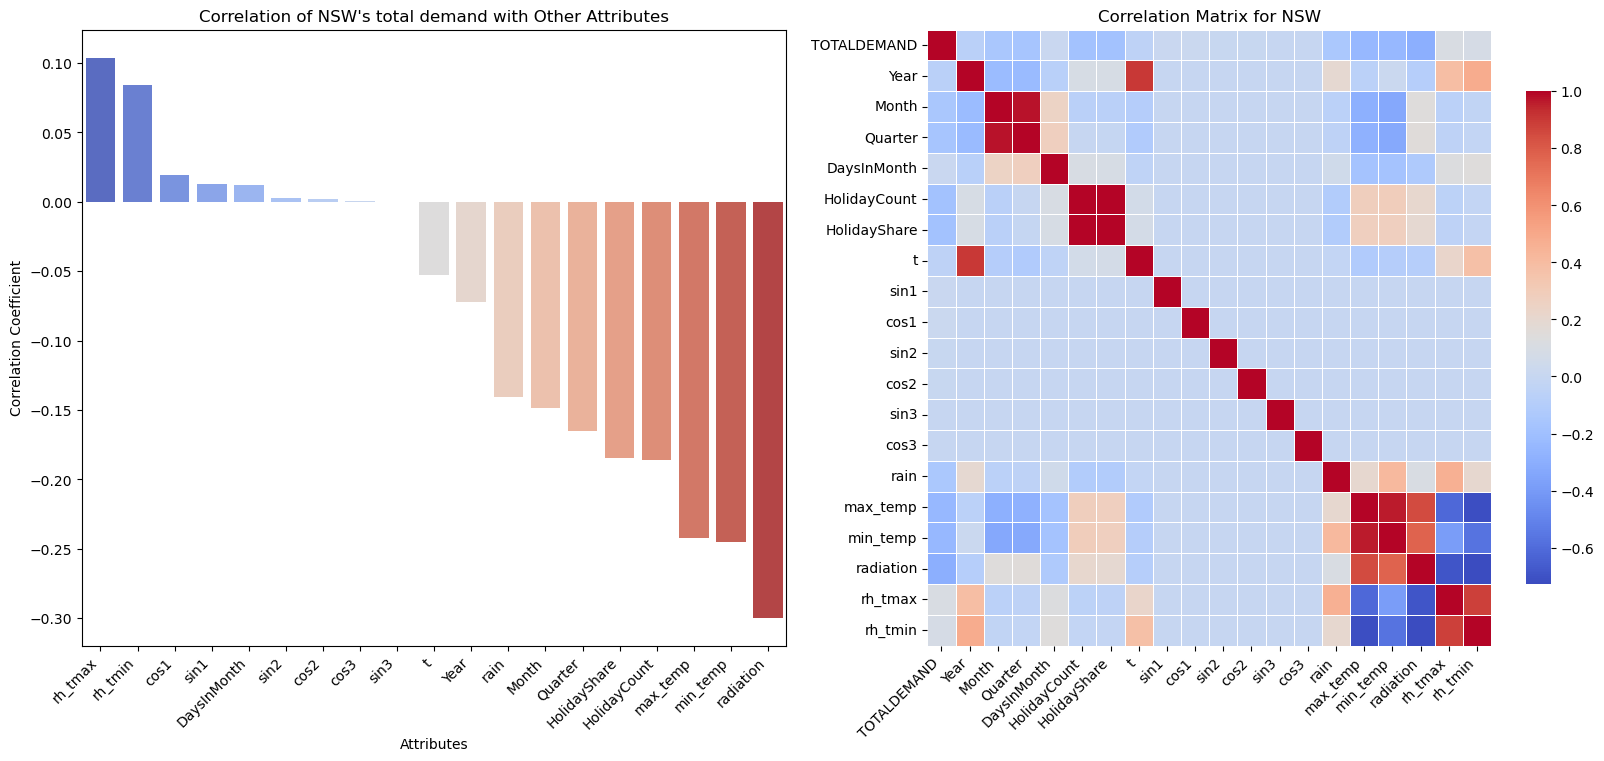

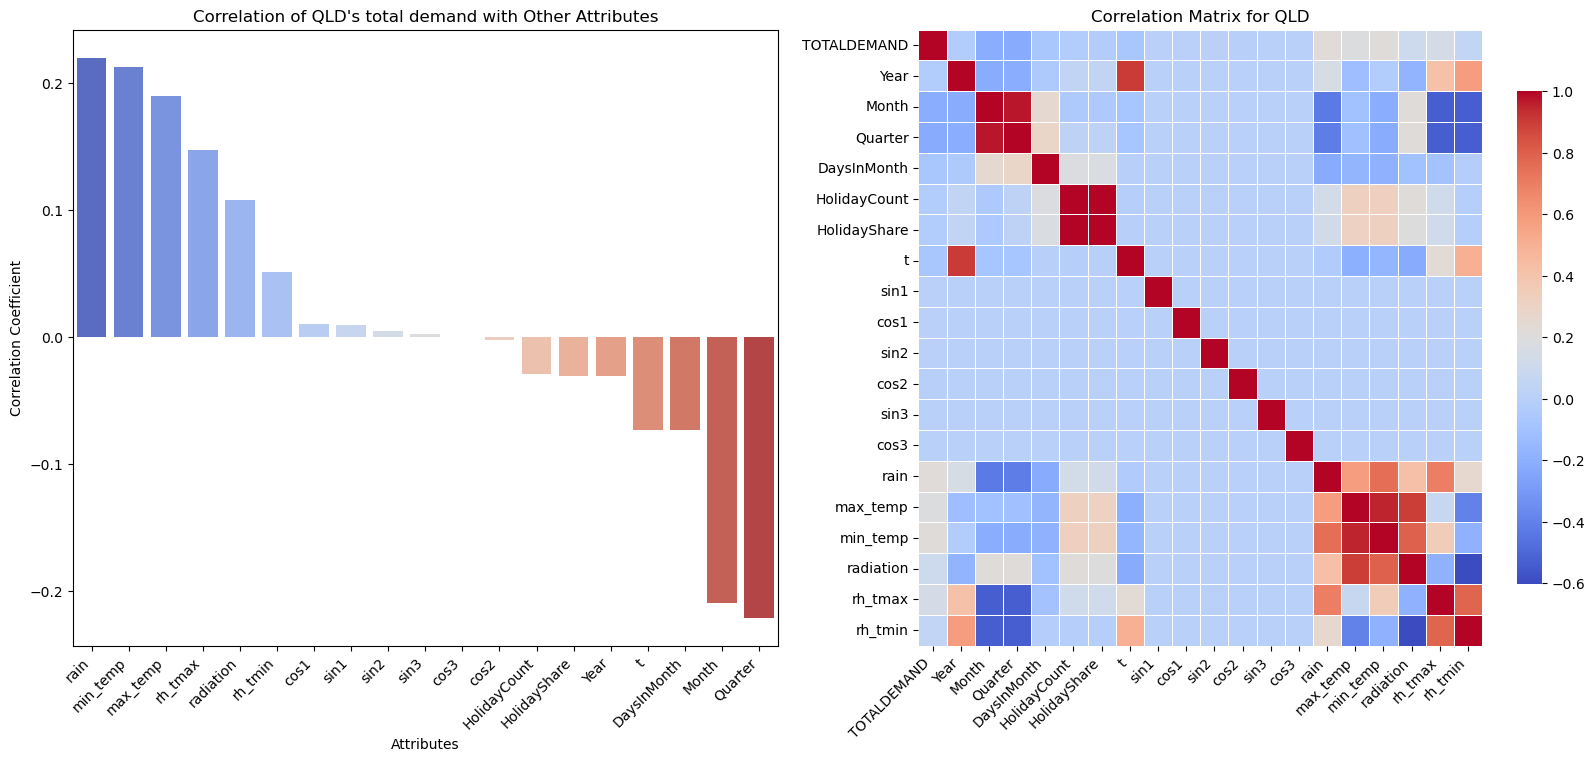

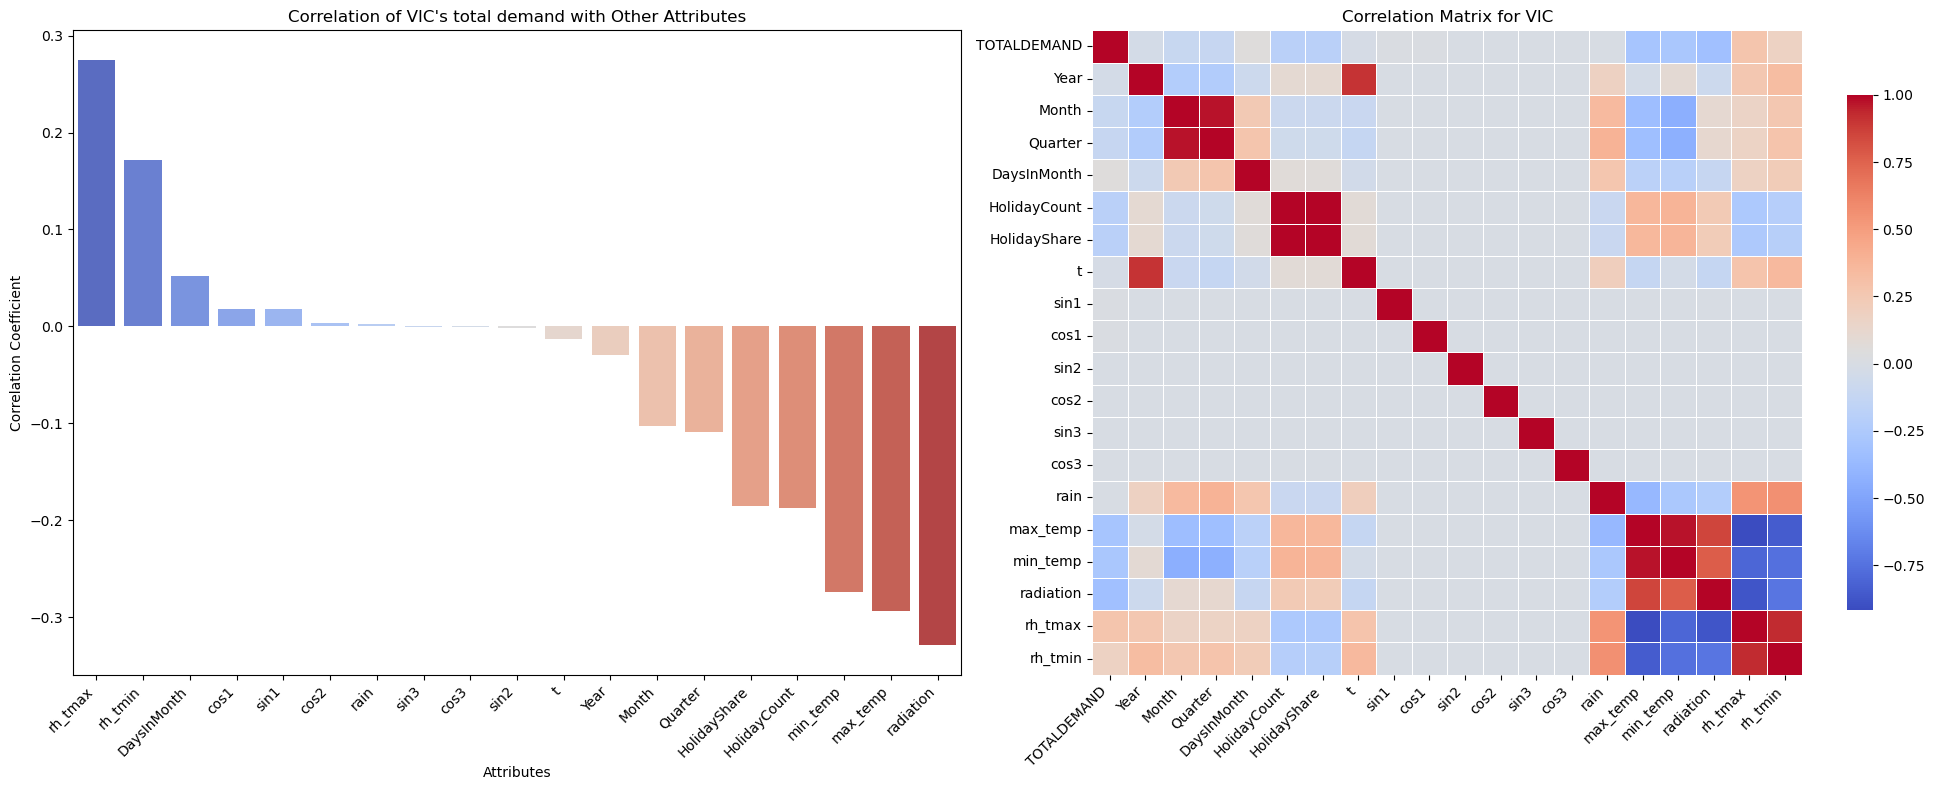

In [105]:
for state, df in datasets:
    # Create a copy of the data containing only the continuous variables
    continuous_data = df.select_dtypes(include=['number']).copy()

    # Compute the correlation matrix
    correlation_matrix = continuous_data.corr()

    # Get the correlation of 'totdemand' with other attributes
    totdemand_corr = correlation_matrix['TOTALDEMAND'].drop('TOTALDEMAND').sort_values(ascending=False)

    # Set up the matplotlib figure
    plt.figure(figsize=(20,8))

    # Create a bar plot of the correlation values
    plt.subplot(1, 2, 1)
    sns.barplot(x=totdemand_corr.index, y=totdemand_corr.values, palette='coolwarm')

    # Set title and labels
    plt.title(f'Correlation of {state}\'s total demand with Other Attributes')
    plt.xlabel('Attributes')
    plt.ylabel('Correlation Coefficient')

    plt.xticks(rotation=45, ha='right')

    plt.subplot(1, 2, 2)
    sns.heatmap(correlation_matrix, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8}, linewidths=0.5)
    plt.title(f'Correlation Matrix for {state}')

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45, ha='right')

# Use tight layout for better spacing
plt.tight_layout()
plt.show()

In [106]:
NSW_data = NSW_data.set_index('SETTLEMENTDATE')
QLD_data = QLD_data.set_index('SETTLEMENTDATE') 
VIC_data = VIC_data.set_index('SETTLEMENTDATE')

In [107]:
def type_agg(df):
    """Automatically aggregate DataFrame with appropriate functions for each column type"""
    agg_dict = {}
    
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:  # Numerical columns
            agg_dict[col] = 'mean'
        elif df[col].dtype == 'object':  # Categorical/string columns  
            agg_dict[col] = 'first'
        else:  # Other types (datetime, etc.)
            agg_dict[col] = 'first'
    
    return df.resample('MS').agg(agg_dict)

NSW_monthly = type_agg(NSW_data)
QLD_monthly = type_agg(QLD_data)
VIC_monthly = type_agg(VIC_data)

print("\nUsing type aggregation:")
print("NSW monthly (type):")
NSW_monthly.head()


Using type aggregation:
NSW monthly (type):


,REGION,TOTALDEMAND,RRP,PERIODTYPE,Year,Month,Quarter,Season,DaysInMonth,HolidayCount,...,sin3,cos3,REGION_STD,ym,rain,max_temp,min_temp,radiation,rh_tmax,rh_tmin
SETTLEMENTDATE,,,,,,,,,,,,,,,,,,,,,
2018-01-01,NSW1,8365.807357,91.86,TRADE,2018,1,1,summer,31,2,...,6.724950e-04,-9.215523e-16,NSW,2018-01,48.08,31.633548,17.253548,24.767742,38.290968,82.457742
2018-02-01,NSW1,8216.016957,64.09,TRADE,2018,2,1,summer,28,0,...,3.171930e-16,3.426492e-16,NSW,2018-02,67.17,29.710000,16.009286,21.632500,39.964643,84.080000
2018-03-01,NSW1,7813.076559,61.35,TRADE,2018,3,1,autumn,31,2,...,1.156371e-15,-3.715815e-15,NSW,2018-03,59.05,27.756774,14.464839,18.177419,42.816774,87.855806
2018-04-01,NSW1,7544.269535,68.24,TRADE,2018,4,2,autumn,30,3,...,-1.564299e-14,-1.721462e-15,NSW,2018-04,27.77,25.871333,12.072333,14.829333,42.707333,89.943000
2018-05-01,NSW1,7896.182534,60.77,TRADE,2018,5,2,autumn,31,0,...,1.154933e-14,9.133077e-15,NSW,2018-05,23.24,19.298710,6.134839,11.416129,45.878710,94.024194


In [108]:
month_list = [("QLD_monthly", QLD_monthly), ("NSW_monthly", NSW_monthly), ("VIC_monthly", VIC_monthly)]

columns_to_drop = ['PERIODTYPE', 'REGION_STD', 'REGION']
NSW_monthly = NSW_monthly.drop(columns=columns_to_drop, axis=1)
QLD_monthly = QLD_monthly.drop(columns=columns_to_drop, axis=1)
VIC_monthly = VIC_monthly.drop(columns=columns_to_drop, axis=1)

In [109]:
NSW_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66 entries, 2018-01-01 to 2023-06-01
Freq: MS
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype    
---  ------        --------------  -----    
 0   TOTALDEMAND   66 non-null     float64  
 1   RRP           66 non-null     object   
 2   Year          66 non-null     int32    
 3   Month         66 non-null     int32    
 4   Quarter       66 non-null     int32    
 5   Season        66 non-null     category 
 6   DaysInMonth   66 non-null     int32    
 7   HolidayCount  66 non-null     int32    
 8   HolidayShare  66 non-null     float64  
 9   t             66 non-null     float64  
 10  sin1          66 non-null     float64  
 11  cos1          66 non-null     float64  
 12  sin2          66 non-null     float64  
 13  cos2          66 non-null     float64  
 14  sin3          66 non-null     float64  
 15  cos3          66 non-null     float64  
 16  ym            66 non-null     period[M]
 17  rain    

## Dynamic regression (ARIMA + Linear)

In [110]:
def prep_monthly(df, region_name):
    g = df.copy()
    g = g.rename(columns={'TOTALDEMAND':'y'})
    g['unique_id'] = region_name
    g = g.reset_index().rename(columns={'SETTLEMENTDATE':'ds'}) if 'SETTLEMENTDATE' in g.index.names else g
    if 'ds' not in g.columns:
        g = g.reset_index().rename(columns={'index':'ds'})
    g['ds'] = pd.to_datetime(g['ds'])
    return g

nsw = prep_monthly(NSW_monthly, 'NSW')
qld = prep_monthly(QLD_monthly, 'QLD')
vic = prep_monthly(VIC_monthly, 'VIC')

df_all = pd.concat([nsw, qld, vic], ignore_index=True)

In [111]:
EXOG_VARS = [
    'Month','Quarter','Season','DaysInMonth','HolidayShare','t',
    'sin1','cos1','sin2','cos2','sin3','cos3',
    'rain','max_temp','min_temp','radiation','rh_tmax','rh_tmin'
]

H = 12  # forecast horizon = 12 months

def add_split(g):
    g = g.sort_values('ds').copy()
    g['is_test'] = False
    g.loc[g.index[-H:], 'is_test'] = True
    return g

df_all = df_all.groupby('unique_id', group_keys=False).apply(add_split)

train_sf = df_all[df_all['is_test']==False][['unique_id','ds','y']+EXOG_VARS]
test_X   = df_all[df_all['is_test']==True][['unique_id','ds']+EXOG_VARS]

In [112]:
def build_exog_safe(df, region):
    g = df.copy()

    # If the index is PeriodIndex (e.g., monthly), convert to Timestamp first
    if isinstance(g.index, pd.PeriodIndex):
        g.index = g.index.to_timestamp(how='S')  # month-start

    # Bring the datetime index out as a column (name could be anything or None)
    g = g.reset_index()

    # Standardize target & id
    g = g.rename(columns={'TOTALDEMAND': 'y'})
    g['unique_id'] = region

    # --- find timestamp column and rename to 'ds' ---
    ts_candidates = ['ds', 'SETTLEMENTDATE', 'SettlementDate', 'DATE', 'Date', 'timestamp', 'index']
    ts_col = next((c for c in ts_candidates if c in g.columns), None)

    if ts_col is None:
        # fallback: pick the first datetime64 column
        dt_cols = g.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns.tolist()
        if dt_cols:
            ts_col = dt_cols[0]
        else:
            # as a last resort, try to parse any object column that looks like dates
            obj_cols = g.select_dtypes(include=['object']).columns
            for c in obj_cols:
                try:
                    tmp = pd.to_datetime(g[c], errors='raise')
                    g[c] = tmp
                    ts_col = c
                    break
                except Exception:
                    pass

    if ts_col is None:
        raise KeyError(f"No datetime column found after reset_index(). Columns: {g.columns.tolist()}")

    if ts_col != 'ds':
        g = g.rename(columns={ts_col: 'ds'})

    g['ds'] = pd.to_datetime(g['ds'])

    # ------- exogenous variables (choose one seasonal encoding) -------
    # Use Month dummies (drop_first=True) and avoid Quarter/Season and sin/cos to prevent collinearity
    BASE = ['t', 'DaysInMonth', 'HolidayShare',
            'rain', 'max_temp', 'min_temp', 'radiation', 'rh_tmax', 'rh_tmin']

    # ensure Month exists and is int
    if 'Month' not in g.columns:
        g['Month'] = g['ds'].dt.month
    g['Month'] = g['Month'].astype(int)

    m_dum = pd.get_dummies(g['Month'], prefix='m', drop_first=True, dtype=float)
    X = pd.concat([g[BASE].reset_index(drop=True), m_dum.reset_index(drop=True)], axis=1)

    # drop constant cols
    X = X.loc[:, X.nunique() > 1]

    # final modelling frame
    out = pd.concat([g[['unique_id', 'ds', 'y']].reset_index(drop=True), X], axis=1)
    return out

In [113]:
nsw = build_exog_safe(NSW_monthly, 'NSW')
qld = build_exog_safe(QLD_monthly, 'QLD')
vic = build_exog_safe(VIC_monthly, 'VIC')

df_all = pd.concat([nsw, qld, vic], ignore_index=True)

print(df_all[['unique_id','ds','y']].head())   # sanity check: 'ds' exists


  unique_id         ds            y
0       NSW 2018-01-01  8365.807357
1       NSW 2018-02-01  8216.016957
2       NSW 2018-03-01  7813.076559
3       NSW 2018-04-01  7544.269535
4       NSW 2018-05-01  7896.182534


In [114]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

H = 12
def add_split(g):
    g = g.sort_values('ds').copy()
    g['is_test'] = False
    g.loc[g.index[-H:], 'is_test'] = True
    return g

df_all = df_all.groupby('unique_id', group_keys=False).apply(add_split)

EXOG_VARS = [c for c in df_all.columns if c not in ('unique_id','ds','y','is_test')]

train_sf = df_all[df_all['is_test']==False][['unique_id','ds','y']+EXOG_VARS]
test_X   = df_all[df_all['is_test']==True][['unique_id','ds']+EXOG_VARS]

sf = StatsForecast(models=[AutoARIMA(season_length=12)], freq='MS', n_jobs=1)  # n_jobs=1 for clearer errors
sf = sf.fit(df=train_sf, target_col='y')
fc = sf.predict(h=H, X_df=test_X, level=[80,95])

In [115]:
eval_df = df_all[df_all['is_test']][['unique_id','ds','y']].merge(
    fc[['unique_id','ds','AutoARIMA']], on=['unique_id','ds'], how='left'
).rename(columns={'AutoARIMA':'yhat'})

def mae(a,f): return np.mean(np.abs(a-f))
def rmse(a,f): return np.sqrt(np.mean((a-f)**2))

metrics = []
for k,g in eval_df.groupby('unique_id'):
    metrics.append({
        'region':k,
        'MAE':mae(g['y'],g['yhat']),
        'RMSE':rmse(g['y'],g['yhat'])
    })
print(pd.DataFrame(metrics))

  region         MAE        RMSE
0    NSW  222.113152  269.169561
1    QLD  495.621531  540.603155
2    VIC  176.261954  208.073157


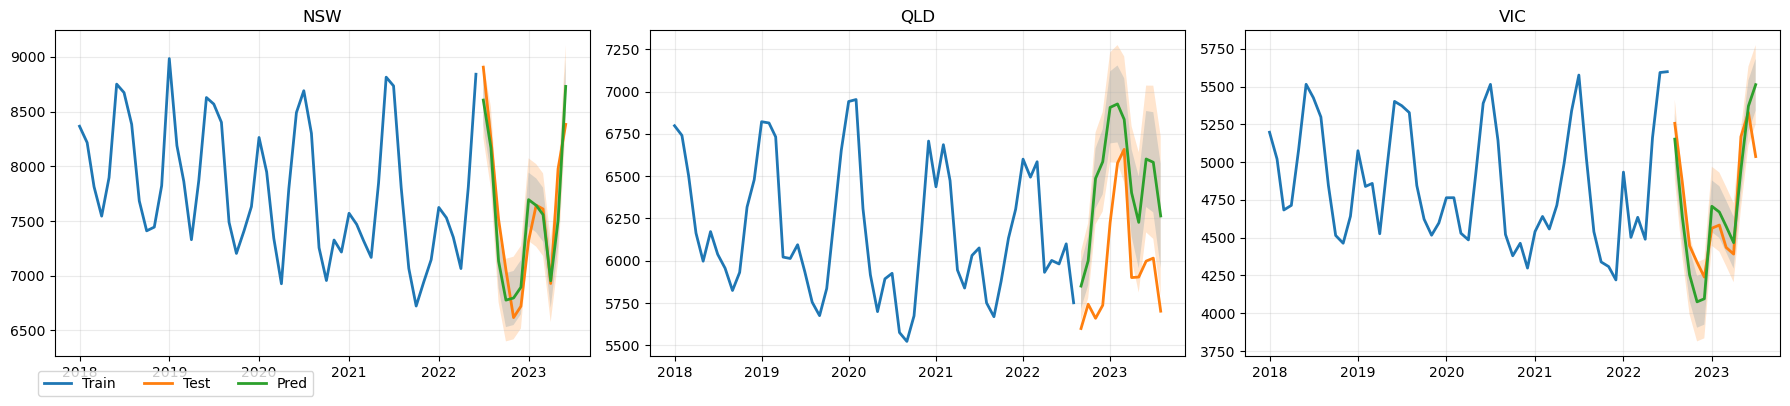

In [116]:
from matplotlib.dates import DateFormatter

def plot_dynamic_regression_panels(df_all, fc, regions=('NSW','QLD','VIC'),
                                   model_col='AutoARIMA', levels=(80, 95)):
    """
    df_all: long df with ['unique_id','ds','y','is_test']
    fc    : StatsForecast predict() output with columns like:
            ['unique_id','ds', model_col, f'{model_col}-lo-80', f'{model_col}-hi-80', ...]
    """
    # make sure datetime
    df_all = df_all.copy()
    df_all['ds'] = pd.to_datetime(df_all['ds'])
    fc = fc.copy()
    fc['ds'] = pd.to_datetime(fc['ds'])

    fig, axes = plt.subplots(1, len(regions), figsize=(18, 4), sharex=False)
    if len(regions) == 1:
        axes = [axes]

    for ax, region in zip(axes, regions):
        # train / test split
        g = df_all[df_all['unique_id'] == region].sort_values('ds')
        tr = g[g['is_test'] == False]
        te = g[g['is_test'] == True]

        # forecasts for this region
        gf = fc[fc['unique_id'] == region].sort_values('ds')

        # --- lines ---
        ax.plot(tr['ds'], tr['y'], color='tab:blue', lw=2, label='Train')
        if not te.empty:
            ax.plot(te['ds'], te['y'], color='tab:orange', lw=2, label='Test')
        ax.plot(gf['ds'], gf[model_col], color='tab:green', lw=2, label='Pred')

        # --- shaded intervals (all levels provided) ---
        for L in sorted(levels):
            lo = f'{model_col}-lo-{L}'
            hi = f'{model_col}-hi-{L}'
            if lo in gf.columns and hi in gf.columns:
                ax.fill_between(gf['ds'], gf[lo], gf[hi], alpha=0.20, edgecolor='none')

        ax.set_title(region)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.grid(alpha=0.25)
        ax.xaxis.set_major_formatter(DateFormatter('%Y'))

    # one legend for the whole row
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.02, -0.02), ncol=3)
    fig.tight_layout()
    plt.show()

plot_dynamic_regression_panels(df_all, fc, regions=('NSW','QLD','VIC'),
                               model_col='AutoARIMA', levels=(80,95))

## 2


In [117]:
def mae(a,f):  return np.mean(np.abs(a-f))
def rmse(a,f): return np.sqrt(np.mean((a-f)**2))
def smape(a,f): return 100*np.mean(2*np.abs(f-a)/(np.abs(a)+np.abs(f)+1e-9))

# seasonal naive vs your current forecast df `fc`
base_rows = []
for region, g in df_all.groupby('unique_id'):
    g = g.sort_values('ds')
    tr = g[g['is_test']==False]['y'].to_numpy()
    te = g[g['is_test']==True].copy()
    yhat = tr[-12:]  # last 12 months as forecast
    te['yhat_snaive'] = yhat
    base_rows.append({
        "region": region,
        "MAE_snaive": mae(te['y'], te['yhat_snaive']),
        "RMSE_snaive": rmse(te['y'], te['yhat_snaive']),
        "sMAPE_snaive": smape(te['y'], te['yhat_snaive'])
    })
print(pd.DataFrame(base_rows))


  region  MAE_snaive  RMSE_snaive  sMAPE_snaive
0    NSW  298.693626   323.081709      3.982356
1    QLD  171.515312   248.940383      2.831278
2    VIC  191.484417   250.556531      3.899246


In [118]:
import numpy as np
import pandas as pd

def add_fourier_monthly(g, K=3):
    m = g['ds'].dt.month.values
    for k in range(1, K+1):
        g[f'sin{k}m'] = np.sin(2*np.pi*k*m/12)
        g[f'cos{k}m'] = np.cos(2*np.pi*k*m/12)
    return g

def prune_qr(X, tol=1e-10):
    A = X.values.astype(float)
    Q, R = np.linalg.qr(A)
    keep = np.where(np.abs(np.diag(R)) > tol)[0]
    return X.iloc[:, keep]

def build_adv(df, region, use_log=False):
    g = df.copy()
    if isinstance(g.index, pd.PeriodIndex):
        g.index = g.index.to_timestamp(how='S')  # month-start
    g = g.reset_index().rename(columns={'index':'ds'})
    g['ds'] = pd.to_datetime(g['ds'])
    g = g.rename(columns={'TOTALDEMAND':'y'})
    g['unique_id'] = region

    # Weather transforms (much better than raw temps at monthly scale)
    g['tmean'] = (g['max_temp'] + g['min_temp'])/2.0
    base = 18.0
    g['CDD'] = np.clip(g['tmean'] - base, 0, None)
    g['HDD'] = np.clip(base - g['tmean'], 0, None)

    # Simple annual seasonality via Fourier
    g = add_fourier_monthly(g, K=3)

    Xcols = ['t','DaysInMonth','HolidayShare','CDD','HDD',
             'sin1m','cos1m','sin2m','cos2m','sin3m','cos3m',
             'rain','radiation','rh_tmax','rh_tmin']
    Xcols = [c for c in Xcols if c in g.columns]

    X = g[Xcols].copy()
    X = X.loc[:, X.nunique() > 1]  # drop constants
    X = prune_qr(X)                 # drop collinear

    if use_log:
        g['y'] = np.log1p(g['y'])

    out = pd.concat([g[['unique_id','ds','y']], X], axis=1)
    return out

In [119]:
import pandas as pd
import numpy as np

def build_adv_safe(df, region, use_log=False, base_temp=18.0):
    g = df.copy()

    # --- 1) Create 'ds' safely ---
    if isinstance(g.index, pd.PeriodIndex):
        ds = g.index.to_timestamp(how='S')         # month-start
        g = g.reset_index(drop=True)
        g.insert(0, 'ds', pd.to_datetime(ds))
    elif isinstance(g.index, pd.DatetimeIndex):
        ds = g.index
        g = g.reset_index(drop=True)
        g.insert(0, 'ds', pd.to_datetime(ds))
    else:
        g = g.reset_index()  # whatever the index name was
        # prefer an existing datetime column
        dt_cols = g.select_dtypes(include=['datetime64[ns]','datetime64[ns, UTC]']).columns.tolist()
        if dt_cols:
            g = g.rename(columns={dt_cols[0]:'ds'})
        elif 'ym' in g.columns:                     # period[M] column in your schema
            g['ds'] = pd.PeriodIndex(g['ym']).to_timestamp(how='S')
        elif {'Year','Month'}.issubset(g.columns):  # synthesize from Year/Month
            g['ds'] = pd.to_datetime(dict(year=g['Year'].astype(int),
                                          month=g['Month'].astype(int),
                                          day=1))
        else:
            # try common names
            for c in ['SETTLEMENTDATE','date','Date','timestamp','INDEX','index','ds']:
                if c in g.columns:
                    g[c] = pd.to_datetime(g[c], errors='coerce')
                    if g[c].notna().any():
                        g = g.rename(columns={c:'ds'})
                        break
        if 'ds' not in g.columns:
            raise KeyError(f"Could not create 'ds'. Columns now: {g.columns.tolist()}")

    g['ds'] = pd.to_datetime(g['ds'])

    # --- 2) Target/id ---
    g = g.rename(columns={'TOTALDEMAND':'y'})
    g['unique_id'] = region

    # --- 3) Weather transforms (CDD/HDD) + Fourier (annual) ---
    if 'max_temp' in g.columns and 'min_temp' in g.columns:
        g['tmean'] = (g['max_temp'] + g['min_temp'])/2.0
        g['CDD'] = np.clip(g['tmean'] - base_temp, 0, None)
        g['HDD'] = np.clip(base_temp - g['tmean'], 0, None)
    else:
        g['CDD'] = 0.0
        g['HDD'] = 0.0

    # Fourier terms (K=3) for 12-month cycle
    m = g['ds'].dt.month.values
    for k in range(1, 4):
        g[f'sin{k}m'] = np.sin(2*np.pi*k*m/12)
        g[f'cos{k}m'] = np.cos(2*np.pi*k*m/12)

    if use_log:
        g['y'] = np.log1p(g['y'])

    # --- 4) Choose exogs (numeric only; avoid Month/Quarter/Season dups) ---
    Xcols = [c for c in [
        't','DaysInMonth','HolidayShare','CDD','HDD',
        'sin1m','cos1m','sin2m','cos2m','sin3m','cos3m',
        'rain','radiation','rh_tmax','rh_tmin'
    ] if c in g.columns]

    X = g[Xcols].select_dtypes(include=[np.number]).copy()
    # drop constant or all-NA columns
    X = X.loc[:, (X.nunique(dropna=True) > 1)]

    out = pd.concat([g[['unique_id','ds','y']].reset_index(drop=True), X.reset_index(drop=True)], axis=1)
    return out

In [120]:
nsw = build_adv_safe(NSW_monthly, 'NSW', use_log=False)
qld = build_adv_safe(QLD_monthly, 'QLD', use_log=False)
vic = build_adv_safe(VIC_monthly, 'VIC', use_log=False)

df2 = pd.concat([nsw,qld,vic], ignore_index=True)
print(df2[['unique_id','ds','y']].head())

  unique_id         ds            y
0       NSW 2018-01-01  8365.807357
1       NSW 2018-02-01  8216.016957
2       NSW 2018-03-01  7813.076559
3       NSW 2018-04-01  7544.269535
4       NSW 2018-05-01  7896.182534


In [121]:
H = 12
def add_split(g):
    g = g.sort_values('ds').copy()
    g['is_test'] = False
    g.loc[g.index[-H:], 'is_test'] = True
    return g

df2 = df2.groupby('unique_id', group_keys=False).apply(add_split)
EXOG = [c for c in df2.columns if c not in ('unique_id','ds','y','is_test')]

train_sf = df2[df2['is_test']==False][['unique_id','ds','y']+EXOG]
test_X   = df2[df2['is_test']==True ][['unique_id','ds']+EXOG]

sf2 = StatsForecast(
    models=[AutoARIMA(season_length=12, max_p=3, max_q=3, max_P=1, max_Q=1)],
    freq='MS',
    n_jobs=1
)
sf2 = sf2.fit(df=train_sf, target_col='y')
fc2  = sf2.predict(h=H, X_df=test_X, level=[80,95])

# metrics
eval2 = df2[df2['is_test']][['unique_id','ds','y']].merge(
    fc2[['unique_id','ds','AutoARIMA']], on=['unique_id','ds'], how='left'
).rename(columns={'AutoARIMA':'yhat'})

rows=[]
for r,g in eval2.groupby('unique_id'):
    rows.append({
        "region": r,
        "MAE":  mae(g['y'], g['yhat']),
        "RMSE": rmse(g['y'], g['yhat']),
        "sMAPE": smape(g['y'], g['yhat'])
    })
print(pd.DataFrame(rows))

  region         MAE        RMSE     sMAPE
0    NSW  223.420763  259.668464  2.972534
1    QLD  188.901150  215.340592  3.166897
2    VIC  155.951708  201.127722  3.221362


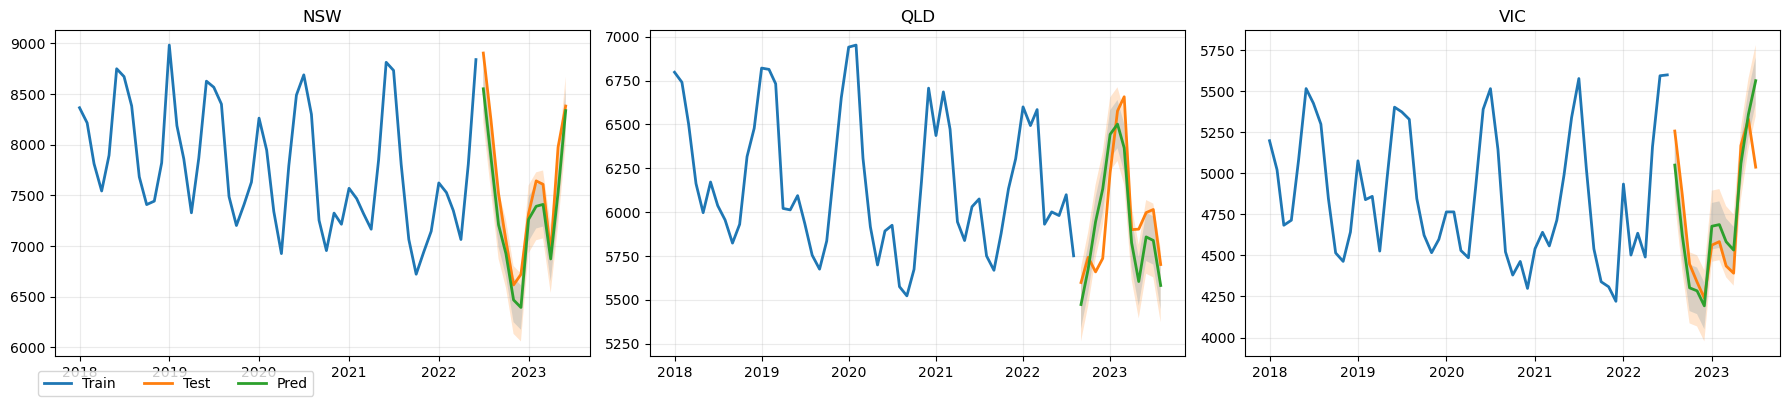

In [122]:
# 1) Make the plotted test window EXACTLY the forecast horizon
df2 = df2.sort_values(['unique_id','ds']).copy()
df2['is_test'] = False
for uid, g in fc2.groupby('unique_id'):
    ds_fore = set(pd.to_datetime(g['ds']))
    mask = (df2['unique_id'].eq(uid) & df2['ds'].isin(ds_fore))
    df2.loc[mask, 'is_test'] = True

# 2) Quick sanity checks
assert df2.groupby('unique_id')['is_test'].sum().equals(fc2.groupby('unique_id').size())
assert set(map(tuple, df2[df2.is_test][['unique_id','ds']].values)) == \
       set(map(tuple, fc2[['unique_id','ds']].values))

# 3) Plot with the SAME forecast object you used for metrics
plot_dynamic_regression_panels(
    df2, fc2,
    regions=('NSW','QLD','VIC'),
    model_col='AutoARIMA',
    levels=(80,95)
)

## DHR

K                1           2           3           4           5           6
region                                                                        
NSW     523.082216  523.082216  523.082216  523.082216  523.082216  523.082216
QLD     412.106982  412.106982  412.106982  412.106982  412.106982  412.106982
VIC     214.900764  214.900764  214.900764  214.900764  214.900764  214.900764
Chosen K=1


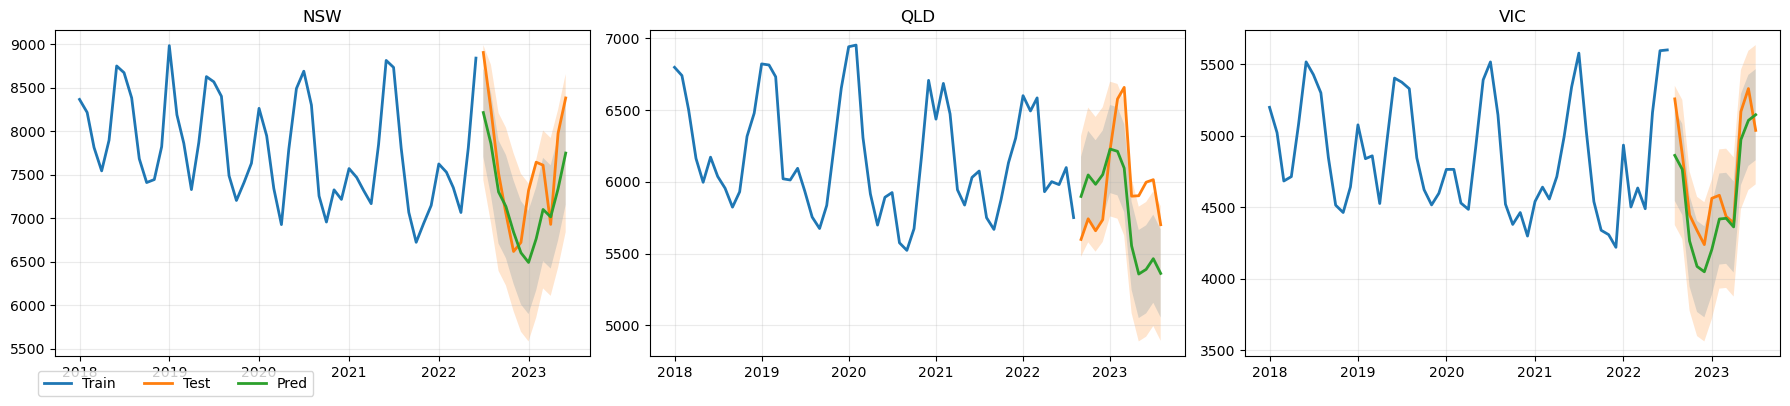

In [123]:
def mae(a,f):  return float(np.mean(np.abs(a-f)))
def rmse(a,f): return float(np.sqrt(np.mean((a-f)**2)))
def smape(a,f): return float(100*np.mean(2*np.abs(f-a)/(np.abs(a)+np.abs(f)+1e-9)))

# df2 must have: ['unique_id','ds','y', sin1..cosK, t, DaysInMonth, HolidayShare, weather...]
# Ensure ds is Timestamp (month-start) and sorted
df2 = df2.sort_values(['unique_id','ds']).copy()

def run_dhr(df_all, K_list=(1,2,3,4,5,6), H=12):
    results = []
    best_fc = {}
    for K in K_list:
        # choose Fourier columns present up to K
        four = sum(([f'sin{k}', f'cos{k}'] for k in range(1, K+1)), [])
        # base exogs (keep only those that exist)
        base = ['t','DaysInMonth','HolidayShare','rain','max_temp','min_temp','radiation','rh_tmax','rh_tmin']
        EXOG = [c for c in base + four if c in df_all.columns]

        # split (last H months per region = test)
        g = df_all.copy()
        g['is_test'] = g.groupby('unique_id')['ds'].transform(lambda s: s.rank(method='first') > (s.size - H))

        train = g[g['is_test']==False][['unique_id','ds','y']+EXOG]
        testX = g[g['is_test']==True ][['unique_id','ds']+EXOG]

        sf = StatsForecast(
            models=[AutoARIMA(seasonal=False, max_p=3, max_q=3, max_P=0, max_Q=0)],
            freq='MS', n_jobs=1
        )
        sf = sf.fit(df=train, target_col='y')
        fc = sf.predict(h=H, X_df=testX, level=[80,95])

        # metrics per region
        eval_df = g[g['is_test']][['unique_id','ds','y']].merge(
            fc[['unique_id','ds','AutoARIMA']], on=['unique_id','ds'], how='left'
        ).rename(columns={'AutoARIMA':'yhat'})

        rows = []
        for r,gr in eval_df.groupby('unique_id'):
            rows.append({
                'K': K, 'region': r,
                'MAE': mae(gr['y'], gr['yhat']),
                'RMSE': rmse(gr['y'], gr['yhat']),
                'sMAPE': smape(gr['y'], gr['yhat']),
                # mean AICc across regions (ARIMA error part)
                'AICc': np.mean([m.model_['aicc'] for m in sf.fitted_[:,0]])
            })
        res = pd.DataFrame(rows)
        results.append(res)
        best_fc[K] = fc

    return pd.concat(results, ignore_index=True), best_fc

# run the sweep
scores, forecasts_by_K = run_dhr(df2, K_list=(1,2,3,4,5,6), H=12)
print(scores.pivot(index='region', columns='K', values='RMSE'))

# pick the K you like (lowest RMSE/AICc)
K_best = int(scores.groupby('K')['RMSE'].mean().idxmin())
fc_best = forecasts_by_K[K_best]
print(f"Chosen K={K_best}")

# (Optional) plot using your helper, ensuring df2.is_test matches fc_best horizon:
df2 = df2.sort_values(['unique_id','ds']).copy()
df2['is_test'] = False
for uid, gfc in fc_best.groupby('unique_id'):
    mask = (df2['unique_id'].eq(uid) & df2['ds'].isin(pd.to_datetime(gfc['ds'])))
    df2.loc[mask, 'is_test'] = True

plot_dynamic_regression_panels(
    df2, fc_best, regions=('NSW','QLD','VIC'), model_col='AutoARIMA', levels=(80,95)
)